# Quantium Virtual Internship - Retail Strategy and Analytics - Task 2

## Introduction

This notebook contains the solution for Task 2 of the Quantium Virtual Internship. 
We will analyze retail data using Python, perform exploratory data analysis, and generate insights.

### Import necessary libraries

In [546]:
# Import necessary libraries
import pandas as pd 
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
# Configure plotting style
plt.style.use('ggplot')

import seaborn as sns

%matplotlib inline

### Set display options for better readability

In [547]:
# Set display options for better readability
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)  # Limit rows displayed
pd.set_option('display.max_colwidth', 100)  # Prevent truncation of long text

In [548]:
# Additional plot settings for cleaner, more readable charts
sns.set_theme(style="whitegrid") 
plt.rcParams['axes.titleweight'] = 'bold'  # Bold titles
plt.rcParams['axes.titlepad'] = 15  # Space around title

### Import dataset

In [549]:
# Specify the file path where the data is stored
file_path = r"C:\Users\Rohith R\Desktop\forage\quantium\task 2"

# Read the transaction data into a pandas dataframe
df = pd.read_csv(file_path+ r"\QVI_data.csv")

df.head()

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream


## Prepare data for analysis
#### 1. Convert the `DATE` Column to Datetime Format
Convert the `DATE` column to a proper datetime format for easier manipulation.

In [550]:
# Convert the DATE column to proper datetime format
df['DATE'] = pd.to_datetime(df['DATE'])

#### 2.Extract Year and Month in 'yyyymm' Format
Create a new column YEARMONTH by extracting the year and month from the DATE column, formatting it as yyyymm, and converting it to an integer.

In [551]:
# Extract year and month in 'yyyymm' format and convert to integer
df['YEARMONTH'] = df['DATE'].dt.strftime('%Y%m').astype(int)

#### 3. Get Store Counts Based on Unique Months
Count the number of unique months each store appears in the dataset.

In [552]:
# Get store counts based on the number of unique months
store_counts = df.groupby('STORE_NBR')['YEARMONTH'].nunique().reset_index()

#### 4. Filter Stores That Operated for the Full 12-Month Pre-Trial Period
- Select only the stores that have data for all 12 months of the pre-trial period.

In [553]:
# Filter stores that operated for the entire 12-month pre-trial period
storesWithFullObs = store_counts[store_counts['YEARMONTH'] == 12]

#### 5. Calculate Monthly Metrics for Each Store
Aggregate key sales performance metrics per store and per month:

* Total Sales (total_sales): Sum of TOT_SALES
* Number of Unique Customers (ncustomers): Count of unique LYLTY_CARD_NBR
* Number of Products Sold (nproducts): Sum of PROD_QTY
* Number of Transactions (monthly_transaction): Count of TXN_ID

In [554]:
# Calculate monthly metrics for each store
measureOverTime = df.groupby(['STORE_NBR', 'YEARMONTH']).agg(
    total_sales=('TOT_SALES', 'sum'),
    ncustomers=('LYLTY_CARD_NBR', 'nunique'),
    nproducts=('PROD_QTY', 'sum'),
    monthly_transaction=('TXN_ID', 'count')
).reset_index()

#### 6. Calculate Additional Metrics
We derive new performance metrics to analyze store-level trends:

1. **Average Number of Chips per Transaction (`nChipsPerTxn`)**  
   - `nproducts / monthly_transaction`: Measures the average quantity of chips sold per transaction.  

2. **Average Transactions per Customer (`nTxnPerCust`)**  
   - `monthly_transaction / ncustomers`: Shows how frequently a customer purchases.  

3. **Average Price per Unit (`avgPricePerUnit`)**  
   - `total_sales / nproducts`: Calculates the average price per unit of chips sold.

In [555]:
# Calculate additional metrics
measureOverTime['nChipsPerTxn'] = measureOverTime['nproducts'] / measureOverTime['monthly_transaction']
measureOverTime['nTxnPerCust'] = measureOverTime['monthly_transaction'] / measureOverTime['ncustomers']
measureOverTime['avgPricePerUnit'] = measureOverTime['total_sales'] / measureOverTime['nproducts']

measureOverTime.head()

,STORE_NBR,YEARMONTH,total_sales,ncustomers,nproducts,monthly_transaction,nChipsPerTxn,nTxnPerCust,avgPricePerUnit
0,1,201807,206.9,49,62,52,1.192308,1.061224,3.337097
1,1,201808,176.1,42,54,43,1.255814,1.023810,3.261111
2,1,201809,278.8,59,75,62,1.209677,1.050847,3.717333
3,1,201810,188.1,44,58,45,1.288889,1.022727,3.243103
4,1,201811,192.6,46,57,47,1.212766,1.021739,3.378947


#### 6. **Filter Pre-Trial Period and Stores with Full Observation**
We need to focus on data for the **pre-trial period** and only include stores that have data for the **entire 12-month pre-trial period**.

#### **Steps:**
1. **Filter the dataset** to include only months **before February 2019** (`YEARMONTH < 201902`).
2. **Select stores** that have been observed for the full pre-trial period (from `storesWithFullObs`).


In [556]:
# Filter to include only the pre-trial period (before February 2019) and stores that have a full 12-month observation period
preTrialMeasures = measureOverTime[(measureOverTime['YEARMONTH'] < 201902) & 
                                   (measureOverTime['STORE_NBR'].isin(storesWithFullObs['STORE_NBR']))]

# Display the first few rows of the filtered dataset
preTrialMeasures.head()

,STORE_NBR,YEARMONTH,total_sales,ncustomers,nproducts,monthly_transaction,nChipsPerTxn,nTxnPerCust,avgPricePerUnit
0,1,201807,206.9,49,62,52,1.192308,1.061224,3.337097
1,1,201808,176.1,42,54,43,1.255814,1.023810,3.261111
2,1,201809,278.8,59,75,62,1.209677,1.050847,3.717333
3,1,201810,188.1,44,58,45,1.288889,1.022727,3.243103
4,1,201811,192.6,46,57,47,1.212766,1.021739,3.378947


## Create Function to Calculate Correlation

This function calculates the Pearson correlation for a specified metric between each trial store and every control store in the dataset. It works as follows:

1. **Input Parameters:**
   - `data`: The DataFrame containing the store data.
   - `metric_column`: The name of the column for which the correlation is calculated.
   - `trial_store_numbers`: A list of trial store numbers for which the correlations will be computed.

2. **Processing:**
   - The function extracts the unique store numbers from the data.
   - For each trial store in `trial_store_numbers`, it loops through all other stores (control stores).
   - For each pair, if the series lengths are equal and have more than one observation, it computes the Pearson correlation; otherwise, it assigns `None`.

3. **Output:**
   - Returns a DataFrame with columns: `Trial_Store`, `Control_Store`, and `Correlation`, containing the computed correlation values.


In [557]:
import pandas as pd

def calculate_correlation(data, metric_column, trial_store_numbers):
    results = []

    unique_stores = data['STORE_NBR'].unique()
    
    for trial_store_number in trial_store_numbers:
        trial_store_data = data[data['STORE_NBR'] == trial_store_number][metric_column].reset_index(drop=True)
        
        for control_store in unique_stores:
            if control_store != trial_store_number:
                control_store_data = data[data['STORE_NBR'] == control_store][metric_column].reset_index(drop=True)

                # Ensure both series are of equal length and contain valid values
                if len(trial_store_data) == len(control_store_data) and len(trial_store_data) > 1:
                    corr_value = trial_store_data.corr(control_store_data)
                else:
                    corr_value = None  # Handle invalid cases

                results.append({
                    'Trial_Store': trial_store_number,
                    'Control_Store': control_store,
                    'Correlation': corr_value
                })

    # Create DataFrame **outside** the loop for efficiency
    correlation_results = pd.DataFrame(results)
    
    return correlation_results

## Create Function to Calculate Standardized Magnitude Distance

This function calculates the **standardized magnitude distance** between a trial store and all control stores for a given metric.

### **Steps:**
1. **Copy the input table** to avoid modifying the original dataset.
2. **Extract the trial store data** for comparison.
3. **Merge** the trial store’s metric data with the entire dataset using `YEARMONTH` to align data points.
4. **Compute the absolute difference** between the trial store and each control store.
5. **Exclude the trial store** from the comparison.
6. **Standardize the magnitude difference** on a scale from `0 to 1`:
   - The minimum absolute difference is assigned a score of `1` (most similar).
   - The maximum absolute difference is assigned a score of `0` (least similar).
7. **Aggregate results** to get the **average magnitude score** per store.
8. **Return** a DataFrame with `STORE_NBR` and its corresponding `magnitude_score`.

In [558]:
def calculate_magnitude_distance(input_table, metric_col, trial_store):
    # Copy the input table to avoid modifying the original
    magnitude_distance = input_table.copy()

    # Get the data for the trial store
    trial_store_data = magnitude_distance[magnitude_distance['STORE_NBR'] == trial_store]

    # Merge trial store data with the full dataset on 'YEARMONTH'
    magnitude_distance = magnitude_distance.merge(
        trial_store_data[['YEARMONTH', metric_col]],
        on='YEARMONTH',
        suffixes=('', '_trial')
    )

    # Calculate the absolute difference between trial store and other stores
    magnitude_distance['abs_diff'] = abs(magnitude_distance[metric_col] - magnitude_distance[f'{metric_col}_trial'])

    # Remove the trial store from the comparison
    magnitude_distance = magnitude_distance[magnitude_distance['STORE_NBR'] != trial_store]

    # Standardize the magnitude distance (scale from 0 to 1)
    min_diff = magnitude_distance['abs_diff'].min()
    max_diff = magnitude_distance['abs_diff'].max()

    magnitude_distance['magnitude_score'] = 1 - (magnitude_distance['abs_diff'] - min_diff) / (max_diff - min_diff)

    # Final table with average magnitude scores per store
    final_magnitude_table = magnitude_distance.groupby('STORE_NBR')['magnitude_score'].mean().reset_index()

    return final_magnitude_table


## Finding Control Stores for Trial Store 77

To identify control stores, we will evaluate how similar each store is to **Trial Store 77** based on two key metrics:

1. **Correlation Scores**: Measures how closely the trends in total sales and number of customers match those of Trial Store 77.
2. **Magnitude Scores**: Measures how similar the total sales and number of customers are in absolute size compared to Trial Store 77.

We will compute:
- **`corr_nSales`**: Correlation of total sales between stores.
- **`corr_nCustomers`**: Correlation of number of customers between stores.
- **`magnitude_nSales`**: Magnitude similarity in total sales.
- **`magnitude_nCustomers`**: Magnitude similarity in number of customers.


In [559]:
# Compute correlation scores to measure trend similarity
corr_nSales = calculate_correlation(preTrialMeasures, 'total_sales', [77])
corr_nCustomers = calculate_correlation(preTrialMeasures, 'ncustomers', [77])

# Compute magnitude scores to measure size similarity
magnitude_nSales = calculate_magnitude_distance(preTrialMeasures, 'total_sales', 77)
magnitude_nCustomers = calculate_magnitude_distance(preTrialMeasures, 'ncustomers', 77)

# Display results
print("Correlation of Total Sales:")
display(corr_nSales.head())

print("\nCorrelation of Number of Customers:")
display(corr_nCustomers.head())

print("\nMagnitude Distance for Total Sales:")
display(magnitude_nSales.head())

print("\nMagnitude Distance for Number of Customers:")
display(magnitude_nCustomers.head())


Correlation of Total Sales:


,Trial_Store,Control_Store,Correlation
0,77,1,0.075218
1,77,2,-0.263079
2,77,3,0.806644
3,77,4,-0.263300
4,77,5,-0.110652



Correlation of Number of Customers:


,Trial_Store,Control_Store,Correlation
0,77,1,0.322168
1,77,2,-0.572051
2,77,3,0.834207
3,77,4,-0.295639
4,77,5,0.370659



Magnitude Distance for Total Sales:


,STORE_NBR,magnitude_score
0,1,0.956978
1,2,0.941464
2,3,0.402104
3,4,0.237849
4,5,0.585403



Magnitude Distance for Number of Customers:


,STORE_NBR,magnitude_score
0,1,0.945055
1,2,0.929945
2,3,0.388736
3,4,0.244505
4,5,0.516484


### 1. Calculate Control Store Metrics and Combine Scores  

In this step, we combine the magnitude and correlation scores into a single table and create a composite score that balances the two metrics equally. This composite score will help identify the most suitable control store for the trial store.  

#### Methodology  

1. **Merge Tables:**  
   - We merge the `magnitude_nSales` table with the `corr_nSales` table on the control store number (`STORE_NBR` and `Control_Store`).  

2. **Calculate Combined Score:**  
   - The **composite score (`c_score`)** is computed as the average of correlation and magnitude scores:  

     \[
     c\_score = 0.5 × text{Correlation} + 0.5 × text{Magnitude Score}
     \]

3. **Sort by Score:**  
   - Finally, we sort the results in descending order to identify the store with the highest similarity to the trial store.  


In [560]:
# Combine magnitude and correlation scores for total sales
combined_index_sales = magnitude_nSales.merge(
    corr_nSales,
    left_on='STORE_NBR',        # Matching store numbers
    right_on='Control_Store',   
    suffixes=('', '_trial')
)

# Calculate combined similarity score for sales
combined_index_sales['sales_c_score'] = (
    0.5 * combined_index_sales['Correlation'] + 
    0.5 * combined_index_sales['magnitude_score']
)

# Sort stores by combined score in descending order
combined_index_sales = combined_index_sales.sort_values(by='sales_c_score', ascending=False)

# Combine magnitude and correlation scores for customer count
combined_index_cust = magnitude_nCustomers.merge(
    corr_nCustomers,
    left_on='STORE_NBR',
    right_on='Control_Store',
    suffixes=('', '_trial')
)

# Calculate combined similarity score for customer count
combined_index_cust['cust_c_score'] = (
    0.5 * combined_index_cust['Correlation'] + 
    0.5 * combined_index_cust['magnitude_score']
)

# Sort stores by combined score in descending order
combined_index_cust = combined_index_cust.sort_values(by='cust_c_score', ascending=False)

# Display results
print("Top Control Stores Based on Sales Similarity:")
display(combined_index_sales.head())

print("\nTop Control Stores Based on Customer Count Similarity:")
display(combined_index_cust.head())


Top Control Stores Based on Sales Similarity:


,STORE_NBR,magnitude_score,Trial_Store,Control_Store,Correlation,sales_c_score
220,233,0.986477,77,233,0.903774,0.945125
38,41,0.967433,77,41,0.783232,0.875332
46,50,0.975067,77,50,0.763866,0.869466
15,17,0.888232,77,17,0.842668,0.865450
107,115,0.937041,77,115,0.689159,0.813100



Top Control Stores Based on Customer Count Similarity:


,STORE_NBR,magnitude_score,Trial_Store,Control_Store,Correlation,cust_c_score
220,233,0.993132,77,233,0.990358,0.991745
240,254,0.940934,77,254,0.916208,0.928571
38,41,0.976648,77,41,0.844219,0.910434
78,84,0.928571,77,84,0.858571,0.893571
15,17,0.965659,77,17,0.747308,0.856484


### 2. Merge Sales and Customer Combined Scores  

Now that we have calculated the combined scores for both **total sales** and **number of customers**, we merge them into a single table. This final step ensures that both aspects are considered when selecting the best control store.  

#### Methodology  

1. **Merge Sales and Customer Scores:**  
   - We merge `combined_index_sales` and `combined_index_cust` on `STORE_NBR` to create a unified table.  

2. **Calculate Final Control Score:**  
   - The **final control score (`final_c_score`)** is computed as:  

     \[
     final\_c\_score = 0.5 × sales\_c\_score + 0.5 × cust\_c\_score
     \]  

   - This ensures that both sales and customer metrics contribute equally to the control store selection.  

3. **Sort by Final Score:**  
   - The stores are sorted in descending order to identify the best control store for the trial store.  


In [561]:
# Merge sales and customer combined scores into a single table
# This ensures both metrics are considered when selecting the best control store
final_combined_index = combined_index_sales.merge(
    combined_index_cust,   # Merge with customer-based scores
    on='STORE_NBR',        # Match stores by store number
    suffixes=('_sales', '_cust')  # Add suffixes to distinguish columns
)

# Calculate the final control score as the average of sales and customer scores
final_combined_index['final_c_score'] = (
    0.5 * final_combined_index['sales_c_score'] +  # Weight for sales similarity
    0.5 * final_combined_index['cust_c_score']     # Weight for customer similarity
)

# Sort stores in descending order to find the best control store
final_combined_index = final_combined_index.sort_values(by='final_c_score', ascending=False)

# Display the final table
final_combined_index.head()


,STORE_NBR,magnitude_score_sales,Trial_Store_sales,Control_Store_sales,Correlation_sales,sales_c_score,magnitude_score_cust,Trial_Store_cust,Control_Store_cust,Correlation_cust,cust_c_score,final_c_score
0,233,0.986477,77,233,0.903774,0.945125,0.993132,77,233,0.990358,0.991745,0.968435
1,41,0.967433,77,41,0.783232,0.875332,0.976648,77,41,0.844219,0.910434,0.892883
3,17,0.888232,77,17,0.842668,0.865450,0.965659,77,17,0.747308,0.856484,0.860967
10,254,0.927417,77,254,0.577108,0.752263,0.940934,77,254,0.916208,0.928571,0.840417
8,84,0.842039,77,84,0.684348,0.763194,0.928571,77,84,0.858571,0.893571,0.828382


### 3. **Select the Most Appropriate Control Store**  

In this step, we identify the most suitable control store for the trial store (**Store 77**) by selecting the store with the highest combined score (`c_score`).  

1. **Identify the Highest Scoring Store:**  
   - Select the store with the highest `c_score`, excluding the trial store itself.  
   - This ensures we choose the most similar store based on both **total sales** and **customer count** metrics.  

2. **Select the Control Store:**  
   - The control store is the one with the highest **combined score**, closest to **1**.  


In [562]:
# Select the most appropriate control store (highest final score, excluding trial store)
control_store = final_combined_index[final_combined_index['STORE_NBR'] != 77].iloc[0]['STORE_NBR']

# Display the selected control store
control_store

233.0

### 4. **Visual Validation of Control and Trial Stores**  

After identifying **Store 233** as the control store for **Trial Store 77**, it’s important to visually validate that the key drivers — **total sales** and **number of customers** — are indeed similar in the period before the trial.  

### **1. Visualizing Total Sales Over Time**  

We’ll compare the **total sales** of the trial store, the control store, and the other stores to see if their trends align closely before the trial period.  

#### **Steps:**  

1. **Categorize Stores:**  
   - Label **Store 77** as the **'Trial'** store.  
   - Label **Store 233** as the **'Control'** store.  
   - Label all other stores as **'Other stores'**.  

2. **Aggregate Data:**  
   - Calculate the **average total sales per month** for each store type.  

3. **Format Dates:**  
   - Convert the **year-month format (`YYYYMM`)** into a proper **date format** for plotting.  

4. **Filter Data:**  
   - Exclude data from the **trial period** and keep only the **pre-trial period** for comparison.  

5. **Plot the Data:**  
   - Use a **line plot** to show **total sales over time** by store type.  


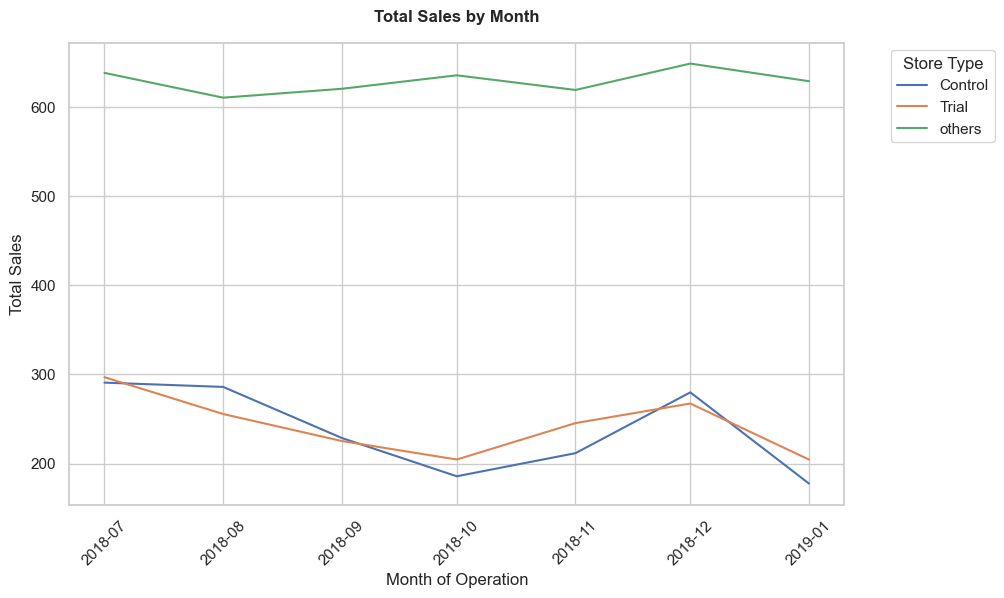

In [563]:
preTrialMeasures_sales = preTrialMeasures.copy()
preTrialMeasures_sales['Store_type'] =  preTrialMeasures_sales['STORE_NBR'].apply(
    lambda x: 'Trial' if x == 77 else ('Control' if x == 233 else 'others')
)

past_sales = preTrialMeasures_sales.groupby(['YEARMONTH', 'Store_type'])['total_sales'].mean().reset_index()

# Convert YEARMONTH to datetime format for plotting
past_sales['TransactionMonth'] = pd.to_datetime(past_sales['YEARMONTH'].astype(str) + '01', format='%Y%m%d')

# Filter data for pre-trial period
past_sales = past_sales[past_sales['YEARMONTH'] < 201903]

# Plot total sales trends
plt.figure(figsize=(10,6))
sns.lineplot(data=past_sales, x='TransactionMonth', y='total_sales', hue='Store_type')
plt.title('Total Sales by Month')
plt.xlabel('Month of Operation')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.legend(title='Store Type')
# Move the legend outside the plot
plt.legend(title='Store Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


### **2. Visualizing Total Customers Over Time**  

We’ll compare the **total customers** of the trial store, the control store, and the other stores to see if their trends align closely before the trial period. 

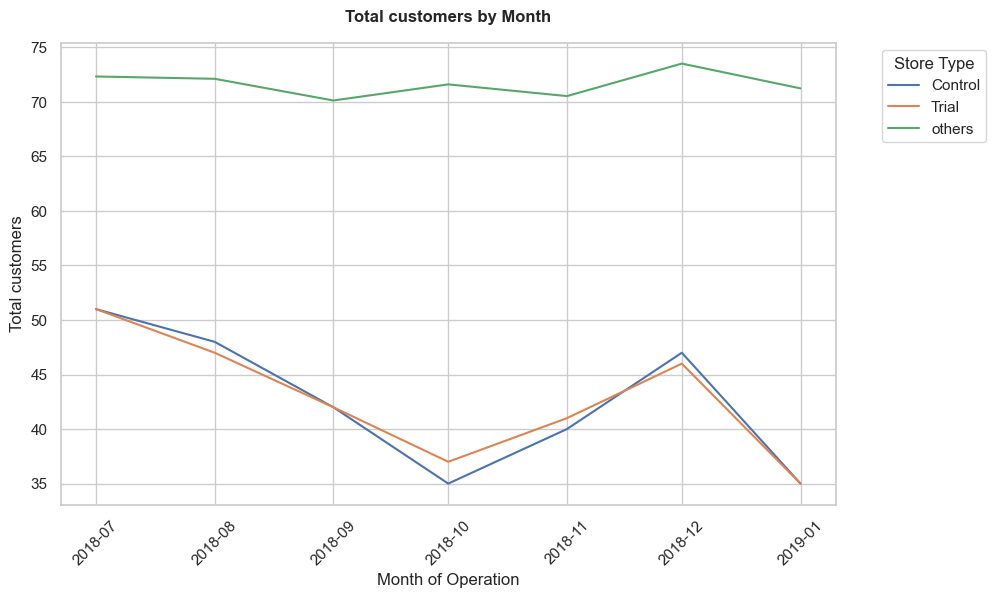

In [564]:
preTrialMeasures_cust = preTrialMeasures_sales.copy()

past_custs = preTrialMeasures_sales.groupby(['YEARMONTH', 'Store_type'])['ncustomers'].mean().reset_index()

# Convert YEARMONTH to datetime format for plotting
past_custs['TransactionMonth'] = pd.to_datetime(past_custs['YEARMONTH'].astype(str) + '01', format='%Y%m%d')

# Filter data for pre-trial period
past_custs = past_custs[past_custs['YEARMONTH'] < 201903]

# Plot total sales trends
plt.figure(figsize=(10,6))
sns.lineplot(data=past_custs, x='TransactionMonth', y='ncustomers', hue='Store_type')
plt.title('Total customers by Month')
plt.xlabel('Month of Operation')
plt.ylabel('Total customers')
plt.xticks(rotation=45)
plt.legend(title='store_type')
# Move the legend outside the plot
plt.legend(title='Store Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

### **Validation of Control Store Selection**  

The visual analysis confirms that **Store 233** closely follows the same trends as **Trial Store 77** in both **total sales** and **customer count** during the pre-trial period. This strong alignment validates Store 233 as a **suitable control store**, ensuring that any observed differences during the trial can be attributed to the intervention rather than pre-existing variations in store performance.


## **Assessment of Trial Performance**  

The trial period runs from **February 2019 to April 2019**. To determine whether the trial led to an **increase in chip sales**, we need to compare the sales of the **trial store (77)** with those of the **control store (233)**.

#### **Scaling Control Store Sales**  

Before evaluating performance, we must **scale the control store’s sales** to align with the trial store’s pre-trial sales. This ensures a fair comparison by accounting for differences in sales levels before the trial.

1. **Calculate Scaling Factor:**  
   - Compute **total pre-trial sales** for both the **trial store (77)** and **control store (233)** (before February 2019).  
   - Compute the scaling factor by dividing total trial store sales by total control store sales for the pre-trial period.

2. **Apply Scaling Factor:**  
   - Adjust the control store's total sales by multiplying them with the scaling factor. 

By scaling the control store’s sales, we ensure that any observed uplift during the trial period is due to the trial intervention rather than pre-existing differences between the stores.


In [565]:
# Calculate total pre-trial sales for the trial store (Store 77)
pretrial_store_total_sales = preTrialMeasures[preTrialMeasures['STORE_NBR'] == 77]['total_sales'].sum()

# Calculate total pre-trial sales for the control store (Store 233)
precontrol_store_total_sales = preTrialMeasures[preTrialMeasures['STORE_NBR'] == 233]['total_sales'].sum()

# Calculate the scaling factor to align control store sales with the trial store
scaling_factor = pretrial_store_total_sales / precontrol_store_total_sales

# Filter data for the trial period (February 2019 to April 2019)
during_trial_measures = measureOverTime[
    (measureOverTime['YEARMONTH'] >= 201902) &
    (measureOverTime['YEARMONTH'] <= 201904) &
    (measureOverTime['STORE_NBR'].isin([77, 233])) 
].copy()

# Apply scaling only to the control store (233)
during_trial_measures['scaled_total_sales'] = during_trial_measures.apply(
    lambda row: row['total_sales'] * scaling_factor if row['STORE_NBR'] == 233 else row['total_sales'],
    axis=1
)

### Calculate Percentage Difference Between Trial and Control Sales (Trial Period)

To evaluate whether there was a significant uplift in total sales during the trial period (February 2019 to April 2019), we compute the percentage difference between the trial store’s actual sales and the scaled control store’s sales.

#### **Steps:**
1. **Extract Trial Store Sales:**  
   - Select total sales data for Store 77 (trial store) during the trial period.

2. **Extract Control Store Sales:**  
   - Select the scaled total sales data for Store 233 (control store) to ensure a fair comparison.

3. **Align Sales Data:**  
   - Merge both datasets on `YEARMONTH` to align their monthly sales performance.

4. **Compute Percentage Difference:**  
   - Calculate the percentage difference using the formula:  

     percentage_diff = ((total_sales_trial - scaled_total_sales_control) / scaled_total_sales_control) * 100  

   - This metric helps assess whether the trial had a significant impact on total sales.

5. **Display the Results:**  
   - Show the calculated percentage difference for each month during the trial period.


In [566]:
# Extract sales data for the trial store (Store 77)
trial_store_sales = during_trial_measures[during_trial_measures['STORE_NBR'] == 77][['STORE_NBR', 'YEARMONTH', 'total_sales']]

# Extract scaled sales data for the control store (Store 233)
control_store_sales = during_trial_measures[during_trial_measures['STORE_NBR'] == 233][['STORE_NBR', 'YEARMONTH', 'scaled_total_sales']]

# Merge both datasets on YEARMONTH to align their monthly performance for comparison
trial_percentage_diff = pd.merge(trial_store_sales, control_store_sales, on='YEARMONTH')

# Calculate the percentage difference between the trial store’s actual sales and the scaled control store’s sales
trial_percentage_diff['percentage_diff'] = (
    (trial_percentage_diff['total_sales'] - trial_percentage_diff['scaled_total_sales']) /
    trial_percentage_diff['scaled_total_sales']
) * 100

# Show the results
trial_percentage_diff


,STORE_NBR_x,YEARMONTH,total_sales,STORE_NBR_y,scaled_total_sales,percentage_diff
0,77,201902,235.0,233,249.762622,-5.910661
1,77,201903,278.5,233,203.802205,36.652103
2,77,201904,263.5,233,162.345704,62.307960


### Calculate Percentage Difference Between Trial and Control Sales (Pre-Trial Period)

To validate the reliability of the control store (Store 233) as a benchmark, we calculate the percentage difference in total sales between the trial store (Store 77) and the control store before the trial period. This ensures that the control store closely mirrors the trial store’s sales trends.

#### **Steps:**
1. **Filter Pre-Trial Data:**  
   - Extract sales data for both the trial and control stores before the trial period.

2. **Separate Trial and Control Sales:**  
   - Create separate datasets for Store 77 (trial store) and Store 233 (control store) with only `YEARMONTH` and `total_sales`.

3. **Scale Control Store Sales:**  
   - Multiply the control store’s total sales by the previously calculated scaling factor to align it with the trial store’s performance.

4. **Align Sales Data:**  
   - Merge both datasets on `YEARMONTH` to ensure a direct month-by-month comparison.

5. **Compute Percentage Difference:**  
   - Calculate the percentage difference between the trial store’s sales and the scaled control store’s sales.  
   - This helps confirm the suitability of Store 233 as the control store.



In [567]:
# Create a copy of the pre-trial dataset to avoid modifying the original data
pre_trial_comparison = preTrialMeasures.copy()

# Filter the dataset to include only the trial store (Store 77) and the control store (Store 233)
pre_trial_comparison = pre_trial_comparison[pre_trial_comparison['STORE_NBR'].isin([77, 233])]

# Extract sales data for the trial store (Store 77), keeping only relevant columns
pre_trial_store_sales = pre_trial_comparison[pre_trial_comparison['STORE_NBR'] == 77][['STORE_NBR', 'YEARMONTH', 'total_sales']]

# Extract sales data for the control store (Store 233), keeping only relevant columns
pre_control_store_sales = pre_trial_comparison[pre_trial_comparison['STORE_NBR'] == 233][['STORE_NBR', 'YEARMONTH', 'total_sales']]

# Scale the control store's total sales using the previously computed scaling factor
# This aligns the control store's performance with the trial store's pre-trial sales
pre_control_store_sales['scaled_sales'] = pre_control_store_sales['total_sales'] * scaling_factor

# Merge the trial store and control store sales data on YEARMONTH
# This allows us to directly compare their monthly sales performance
pre_trial_percentage_diff = pd.merge(pre_trial_store_sales, pre_control_store_sales, on='YEARMONTH')

# Calculate the percentage difference in sales between the trial store and the scaled control store
# Formula: |(Total Sales of Trial Store - Scaled Sales of Control Store)| / Scaled Sales of Control Store
pre_trial_percentage_diff['percent_diff'] = (
    abs(pre_trial_percentage_diff['total_sales_x'] - pre_trial_percentage_diff['scaled_sales']) /
    pre_trial_percentage_diff['scaled_sales']
) * 100

# Display the percentage difference results
pre_trial_percentage_diff


,STORE_NBR_x,YEARMONTH,total_sales_x,STORE_NBR_y,total_sales_y,scaled_sales,percent_diff
0,77,201807,296.8,233,290.7,297.565550,0.257271
1,77,201808,255.5,233,285.9,292.652187,12.694997
2,77,201809,225.2,233,228.6,233.998916,3.760238
3,77,201810,204.5,233,185.7,190.085733,7.583035
4,77,201811,245.3,233,211.6,216.597421,13.251579
5,77,201812,267.3,233,279.8,286.408121,6.671641
6,77,201901,204.4,233,177.5,181.692071,12.498029


## Hypothesis Testing for Trial Period Significance  

### **Objective**  
We aim to determine whether the observed uplift in trial store sales is beyond the natural variation seen before the trial period.

### **Approach**  

1. **Calculate Standard Deviation of Pre-Trial Percentage Difference**  
   - Compute the standard deviation (σ) of the percentage difference in total sales between the trial and control stores during the pre-trial period.  
   - This helps measure how much variation normally exists between the two stores.

2. **Set Degrees of Freedom**  
   - Since we have 7 months of pre-trial data, the degrees of freedom (df) is calculated as:  
     - **df = Number of months - 1 = 7 - 1 = 6**

3. **Formulate the Null Hypothesis (H₀)**  
   - The null hypothesis states that there is **no significant difference** between the trial store (77) and control store (233).  
   - In other words, any observed difference is due to random variation rather than the trial intervention.

4. **Calculate t-Values**  
   - For each month in the trial period, compute the t-value using the formula:  
     - **t-value = (Observed Percentage Difference) / (Standard Deviation of Pre-Trial Percentage Difference)**  

5. **Determine Critical t-Value**  
   - For a **95% confidence level** and **6 degrees of freedom**, obtain the critical t-value from the t-distribution table.  
   - If the computed t-value exceeds this critical value, reject the null hypothesis and conclude that the difference is statistically significant.  

This statistical test ensures that the trial's impact is measured rigorously and not mistaken for normal fluctuations in sales.


In [568]:
import numpy as np
import scipy.stats as stats

# Calculate the standard deviation of the percentage difference in the pre-trial period
# This measures the typical variation between the trial and control stores before the trial
std_dev_percentage = np.std(pre_trial_percentage_diff['percent_diff'], ddof=1)  # ddof=1 for sample standard deviation

# Calculate the degrees of freedom (number of pre-trial months - 1)
degrees_of_freedom = len(pre_trial_percentage_diff) - 1

# Null hypothesis: There is no significant difference between the trial and control stores' sales
# Compute t-values for the trial period to check if the observed difference is statistically significant
trial_percentage_diff['t_value'] = (trial_percentage_diff['percentage_diff'] - 0) / std_dev_percentage

# Determine the critical t-value for a 95% confidence level with the given degrees of freedom
# If a t-value exceeds this critical value, we reject the null hypothesis
critical_t_value = stats.t.ppf(0.975, degrees_of_freedom)  # Two-tailed test (0.975 for 95% CI)

# Print the results for reference
print(f"Standard Deviation: {std_dev_percentage}")
print(f"Degrees of Freedom: {degrees_of_freedom}")
print(f"Critical t-value (95% CI): {critical_t_value}")

# Display the trial period sales percentage difference along with the calculated t-values
print(trial_percentage_diff[['YEARMONTH', 'percentage_diff', 't_value']])


Standard Deviation: 4.994076264142537
Degrees of Freedom: 6
Critical t-value (95% CI): 2.4469118511449692
   YEARMONTH  percentage_diff    t_value
0     201902        -5.910661  -1.183534
1     201903        36.652103   7.339116
2     201904        62.307960  12.476373


We observe that the t-values for March and April exceed the critical t-value at the 95% confidence level, indicating that the increase in sales in the trial store during these months is statistically significant. This suggests that the uplift in sales observed in the trial store is unlikely due to random variation and is instead attributable to the trial intervention.

Conversely, if the t-value for February does not exceed the critical threshold, we infer that the sales difference in February is not statistically significant, meaning the observed change could be due to normal fluctuations rather than the trial effect.

Overall, these results support the hypothesis that the intervention had a positive impact on sales, particularly in March and April.

## **Visualizing Sales Performance with Confidence Intervals**

#### **Objective**  
The purpose of this step is to visualize the total sales of:  
- **Trial store**  
- **Control store**  
- **95th percentile confidence interval of control store sales**  
- **5th percentile confidence interval of control store sales**  

This visualization helps assess **whether the trial store's sales during the trial period significantly deviate from the control store's expected range**.

#### **Approach**  
1. **Prepare the Data**  
   - Extract sales data for the **trial store** and **control store**.  
   - Compute **95th and 5th percentile confidence intervals** for control store sales using the **mean ± 2 × standard deviation** approach.  

2. **Format the Date**  
   - Convert `YEARMONTH` into a **datetime format** for proper plotting.  
   - Reformat the date into a **Month-Year format (e.g., "Feb 2019")** for clarity.  

3. **Visualize the Data**  
   - Plot the **total sales of the trial store and control store**.  
   - Add the **confidence interval bands** (95th and 5th percentile lines).  
   - Highlight the **trial period** to observe if the trial store sales exceed expectations.  

This visualization will help determine if the trial store sales **fall outside the expected range** based on historical patterns, providing a graphical confirmation of the statistical test results.


In [569]:
# Create a copy of the relevant columns from during_trial_measures
during_trial_sales_cf = during_trial_measures[['STORE_NBR', 'YEARMONTH', 'total_sales']].copy()

# Assign store type: Label 'Trial' for Store 77, otherwise 'Control'
during_trial_sales_cf['Store_type'] = during_trial_sales_cf['STORE_NBR'].apply(
    lambda x: 'Trial' if x == 77 else 'Control'
)

# Calculate the confidence interval multiplier (Convert percentage standard deviation to decimal)
multiplier = 2 * (std_dev_percentage / 100)

# Create a DataFrame for the 95th percentile confidence interval of control store sales
controlsales_95 = during_trial_sales_cf[during_trial_sales_cf['Store_type'] == 'Control'].copy()
# Increase total sales by the confidence interval multiplier (mean + 2 * std dev)
controlsales_95['total_sales'] = during_trial_sales_cf['total_sales'] * (1 + multiplier)
# Label it as the 95th percentile confidence interval
controlsales_95['Store_type'] = 'Control 95th % confidence interval'

# Create a DataFrame for the 5th percentile confidence interval of control store sales
controlsales_5 = during_trial_sales_cf[during_trial_sales_cf['Store_type'] == 'Control'].copy()
# Decrease total sales by the confidence interval multiplier (mean - 2 * std dev)
controlsales_5['total_sales'] = during_trial_sales_cf['total_sales'] * (1 - multiplier)
# Label it as the 5th percentile confidence interval
controlsales_5['Store_type'] = 'Control 5th % confidence interval'

# Combine all datasets into a single DataFrame for visualization
trial_assessment = pd.concat([during_trial_sales_cf, controlsales_95, controlsales_5])

# Convert YEARMONTH column to datetime format for accurate plotting
trial_assessment['YEARMONTH'] = pd.to_datetime(trial_assessment['YEARMONTH'], format='%Y%m')

# Create a new column to display the date in "Month Year" format (e.g., "Feb 2019")
trial_assessment['TransactionMonth'] = trial_assessment['YEARMONTH'].dt.strftime('%b %Y')


**Visualizing the Data** 

In [570]:
trial_assessment

,STORE_NBR,YEARMONTH,total_sales,Store_type,TransactionMonth
887,77,2019-02-01,235.000000,Trial,Feb 2019
888,77,2019-03-01,278.500000,Trial,Mar 2019
889,77,2019-04-01,263.500000,Trial,Apr 2019
2706,233,2019-02-01,244.000000,Control,Feb 2019
2707,233,2019-03-01,199.100000,Control,Mar 2019
...,...,...,...,...,...
2707,233,2019-03-01,218.986412,Control 95th % confidence interval,Mar 2019
2708,233,2019-04-01,174.441210,Control 95th % confidence interval,Apr 2019
2706,233,2019-02-01,219.628908,Control 5th % confidence interval,Feb 2019
2707,233,2019-03-01,179.213588,Control 5th % confidence interval,Mar 2019


In [571]:
print(trial_assessment.columns)


Index(['STORE_NBR', 'YEARMONTH', 'total_sales', 'Store_type',
       'TransactionMonth'],
      dtype='object')


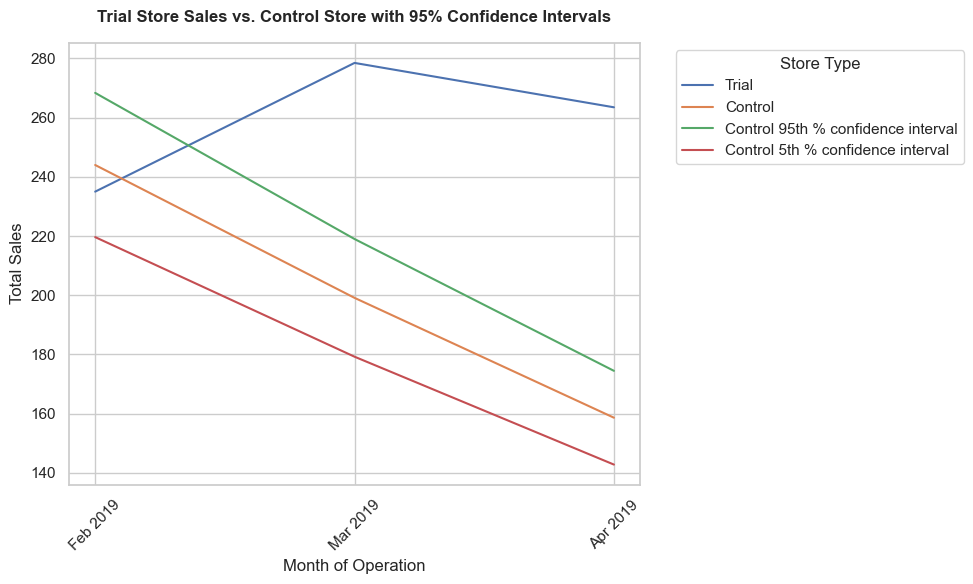

In [572]:
# Set the figure size for better readability
plt.figure(figsize=(10,6))

# Create a line plot for total sales over time, colored by store type
sns.lineplot(data=trial_assessment, x='TransactionMonth', y='total_sales', hue='Store_type')

# Add a title to the plot
plt.title('Trial Store Sales vs. Control Store with 95% Confidence Intervals')

# Label the x-axis
plt.xlabel('Month of Operation')

# Label the y-axis
plt.ylabel('Total Sales')

# Add a legend to indicate store types (Trial, Control, and Confidence Intervals)
plt.legend(title='Store Type')

# Move the legend outside the plot for better visibility
plt.legend(title='Store Type', bbox_to_anchor=(1.05, 1), loc='upper left')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout to prevent overlapping labels
plt.tight_layout()

# Display the plot
plt.show()


The results show that the trial in store 77 is significantly different to its
control store in the trial period as the trial store performance lies outside the
5% to 95% confidence interval of the control store in two of the three trial
months.

## Assessing Customer Trends with Confidence Intervals  

To evaluate whether the trial store experienced a significant change in customer count during the trial period, we will follow the same approach as total sales.  

1. **Scale Pre-Trial Control Store Customers**  
   - Adjust the number of customers in the control store to match the trial store before the trial period.  
   
2. **Calculate  Differences**  
   - Compute the difference between the trial store and scaled control store customers.  

3. **Determine Confidence Intervals**  
   - Compute the standard deviation of percentage differences in customer counts during the pre-trial period.  
   - Define the 95th and 5th percentile confidence intervals (mean ± 2 * standard deviation).  

4. **Visualize the Results**  
   - Plot the trial store's customer count alongside the control store and its confidence intervals.  
   - If the trial store's customer count falls outside the confidence intervals, it suggests a significant change during the trial period.  

This approach allows us to visually assess whether the trial store had a notable increase or decrease in customers without conducting a formal t-test.  



In [573]:
scaling_factor_cust = (
    preTrialMeasures[preTrialMeasures['STORE_NBR'] == 77]['ncustomers'].sum() /
    preTrialMeasures[preTrialMeasures['STORE_NBR'] == 233]['ncustomers'].sum()
)

# Extract customer data for the trial store (Store 77), keeping only relevant columns
pre_trial_store_cust = pre_trial_comparison[pre_trial_comparison['STORE_NBR'] == 77][['STORE_NBR', 'YEARMONTH', 'ncustomers']]

# Extract customer data for the control store (Store 233), keeping only relevant columns
pre_control_store_cust = pre_trial_comparison[pre_trial_comparison['STORE_NBR'] == 233][['STORE_NBR', 'YEARMONTH', 'ncustomers']]

# Scale the control store's total sales using the previously computed scaling factor
# This aligns the control store's performance with the trial store's pre-trial sales
pre_control_store_cust['scaled_cust'] = pre_control_store_cust['ncustomers'] * scaling_factor_cust

# Merge the trial store and control store sales data on YEARMONTH
# This allows us to directly compare their monthly sales performance
pre_trial_diff_cust = pd.merge(pre_trial_store_cust,pre_control_store_cust,on='YEARMONTH')

# Calculate the percentage difference in sales between the trial store and the scaled control store
# Formula: |(Total Sales of Trial Store - Scaled Sales of Control Store)| / Scaled Sales of Control Store
pre_trial_diff_cust['cust_diff'] = (
    abs(pre_trial_diff_cust['ncustomers_x'] - pre_trial_diff_cust['scaled_cust']) /
    pre_trial_diff_cust['scaled_cust']
) 

# Display the percentage difference results
pre_trial_diff_cust

,STORE_NBR_x,YEARMONTH,ncustomers_x,STORE_NBR_y,ncustomers_y,scaled_cust,cust_diff
0,77,201807,51,233,51,51.171141,0.003344
1,77,201808,47,233,48,48.161074,0.024108
2,77,201809,42,233,42,42.140940,0.003344
3,77,201810,37,233,35,35.117450,0.053607
4,77,201811,41,233,40,40.134228,0.021572
5,77,201812,46,233,47,47.157718,0.024550
6,77,201901,35,233,35,35.117450,0.003344


In [574]:
# Calculate the standard deviation of the percentage difference in customer count before the trial
std_dev_cust = np.std(pre_trial_diff_cust['cust_diff'], ddof=1) 

# Create a copy of the relevant columns from during_trial_measures for customer analysis
during_trial_cust_cf = during_trial_measures[['STORE_NBR', 'YEARMONTH', 'ncustomers']].copy()

# Assign store type: Label 'Trial' for Store 77, otherwise 'Control'
during_trial_cust_cf['Store_type'] = during_trial_cust_cf['STORE_NBR'].apply(
    lambda x: 'Trial' if x == 77 else 'Control'
)

# Calculate the confidence interval multiplier (95% CI is typically mean ± 2 * std dev)
multiplier = 2 * std_dev_cust

# Create a DataFrame for the 95th percentile confidence interval of control store customers
controlcust_95 = during_trial_cust_cf[during_trial_cust_cf['Store_type'] == 'Control'].copy()
# Increase customer count by the confidence interval multiplier (mean + 2 * std dev)
controlcust_95['ncustomers'] = controlcust_95['ncustomers'] * (1 + multiplier)
# Label it as the 95th percentile confidence interval
controlcust_95['Store_type'] = 'Control 95th % confidence interval'

# Create a DataFrame for the 5th percentile confidence interval of control store customers
controlcust_5 = during_trial_cust_cf[during_trial_cust_cf['Store_type'] == 'Control'].copy()
# Decrease customer count by the confidence interval multiplier (mean - 2 * std dev)
controlcust_5['ncustomers'] = controlcust_5['ncustomers'] * (1 - multiplier)
# Label it as the 5th percentile confidence interval
controlcust_5['Store_type'] = 'Control 5th % confidence interval'

# Combine all datasets into a single DataFrame for visualization
trial_cust_assessment = pd.concat([during_trial_cust_cf, controlcust_95, controlcust_5])

# Convert YEARMONTH column to datetime format for accurate plotting
trial_cust_assessment['YEARMONTH'] = pd.to_datetime(trial_cust_assessment['YEARMONTH'], format='%Y%m')

# Create a new column to display the date in "Month Year" format (e.g., "Feb 2019")
trial_cust_assessment['TransactionMonth'] = trial_cust_assessment['YEARMONTH'].dt.strftime('%b %Y')


**Visualizing the Data** 

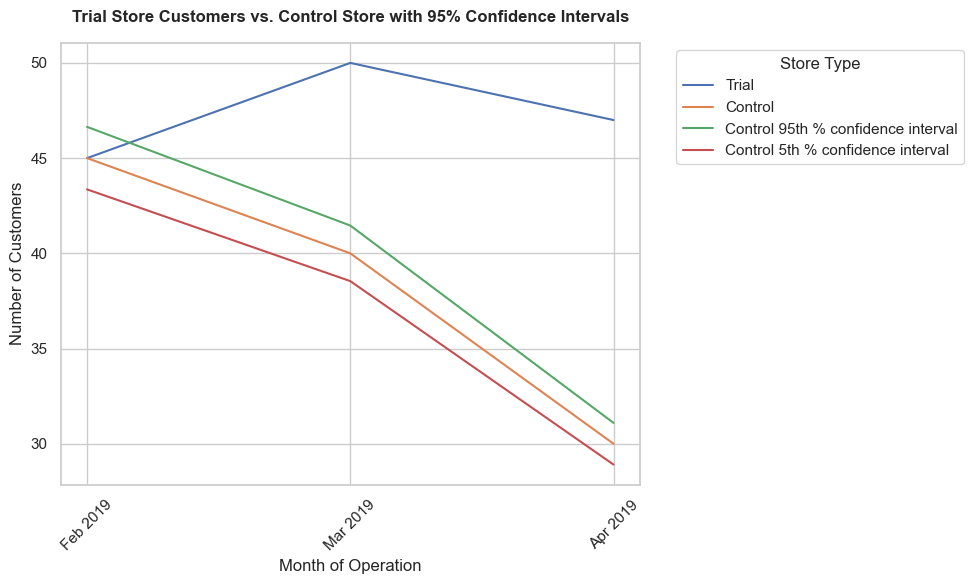

In [575]:
# Set the figure size for better readability
plt.figure(figsize=(10,6))

# Create a line plot for number of customers over time, colored by store type
sns.lineplot(data=trial_cust_assessment, x='TransactionMonth', y='ncustomers', hue='Store_type')

# Add a title to the plot
plt.title('Trial Store Customers vs. Control Store with 95% Confidence Intervals')

# Label the x-axis
plt.xlabel('Month of Operation')

# Label the y-axis
plt.ylabel('Number of Customers')

# Add a legend to indicate store types (Trial, Control, and Confidence Intervals)
plt.legend(title='Store Type')

# Move the legend outside the plot for better visibility
plt.legend(title='Store Type', bbox_to_anchor=(1.05, 1), loc='upper left')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout to prevent overlapping labels
plt.tight_layout()

# Display the plot
plt.show()


The results show that the trial in store 77 is significantly different to its
control store in the trial period as the trial store performance lies outside the
5% to 95% confidence interval of the control store in two of the three trial
months.

### **Findings**  

The results indicate that the trial in Store 77 had a significant impact on both **sales and customer count** compared to its control store during the trial period.  

- In **two out of the three trial months**, the trial store's performance fell **outside the 5% to 95% confidence interval** of the control store for both **total sales and number of customers**.  
- This suggests that the implemented strategy had a measurable effect, leading to a **statistically significant difference** in both key performance indicators.  

Overall, these findings provide strong evidence that the trial intervention influenced customer behavior and sales performance in Store 77, differentiating it from its control counterpart.


## Trial Store 86

### **Applying the Same Methodology to Another Trial-Control Store Pair (Trial Store 86)**  

Having completed the analysis for **Trial Store 77**, we now move forward with evaluating **Trial Store 86** using the same methodology.  

The approach follows the same steps used for Store 77:  
1. **Identifying a suitable control store** for Store 86.  
2. **Scaling the control store's sales and customer count** to match the pre-trial period.  
3. **Calculating percentage differences** and deriving confidence intervals.  
4. **Visualizing the results** to determine whether the trial store's performance significantly deviates from the control store.  

For detailed explanations of each step, please refer to the analysis of **Trial Store 77**. Below is the implementation of these steps for the next trial-control store pair.  


## Finding Control Stores for Trial Store 86

To identify a suitable control store for **Trial Store 86**, we evaluate store similarity based on two key metrics:  

1. **Correlation Scores**: Measures how closely the trends in total sales and number of customers match those of Trial Store 86.  
2. **Magnitude Scores**: Measures how similar the total sales and number of customers are in absolute size compared to Trial Store 86.  

We use the **function created earlier** to compute these metrics and determine the best control store.  

The function calculates the following metrics:  
- **`corr_nSales`**: Correlation of total sales between stores.  
- **`corr_nCustomers`**: Correlation of number of customers between stores.  
- **`magnitude_nSales`**: Magnitude similarity in total sales.  
- **`magnitude_nCustomers`**: Magnitude similarity in number of customers.  

In [576]:
# Compute correlation scores to measure trend similarity
corr_nSales = calculate_correlation(preTrialMeasures, 'total_sales', [86])
corr_nCustomers = calculate_correlation(preTrialMeasures, 'ncustomers', [86])

# Compute magnitude scores to measure size similarity
magnitude_nSales = calculate_magnitude_distance(preTrialMeasures, 'total_sales', 86)
magnitude_nCustomers = calculate_magnitude_distance(preTrialMeasures, 'ncustomers', 86)

# Display results
print("Correlation of Total Sales:")
display(corr_nSales.head())

print("\nCorrelation of Number of Customers:")
display(corr_nCustomers.head())

print("\nMagnitude Distance for Total Sales:")
display(magnitude_nSales.head())

print("\nMagnitude Distance for Number of Customers:")
display(magnitude_nCustomers.head())

Correlation of Total Sales:


,Trial_Store,Control_Store,Correlation
0,86,1,0.445632
1,86,2,-0.403835
2,86,3,-0.261284
3,86,4,-0.039035
4,86,5,0.235159



Correlation of Number of Customers:


,Trial_Store,Control_Store,Correlation
0,86,1,0.485831
1,86,2,-0.086161
2,86,3,-0.353786
3,86,4,-0.169608
4,86,5,-0.253229



Magnitude Distance for Total Sales:


,STORE_NBR,magnitude_score
0,1,0.285102
1,2,0.246060
2,3,0.787731
3,4,0.545856
4,5,0.931291



Magnitude Distance for Number of Customers:


,STORE_NBR,magnitude_score
0,1,0.497354
1,2,0.437831
2,3,0.921958
3,4,0.798942
4,5,0.931217


### Combining Correlation and Magnitude Scores  
To determine the best control store, we combine **trend similarity** (correlation) and **size similarity** (magnitude distance) into a single similarity score.  

The code merges correlation and magnitude scores for **total sales** and **customer count**, calculates a weighted similarity score (50% correlation, 50% magnitude), and ranks stores based on similarity to the trial store.  


In [577]:
# Combine magnitude and correlation scores for total sales
combined_index_sales = magnitude_nSales.merge(
    corr_nSales,
    left_on='STORE_NBR',        # Matching store numbers
    right_on='Control_Store',   
    suffixes=('', '_trial')
)

# Calculate combined similarity score for sales
combined_index_sales['sales_c_score'] = (
    0.5 * combined_index_sales['Correlation'] + 
    0.5 * combined_index_sales['magnitude_score']
)

# Sort stores by combined score in descending order
combined_index_sales = combined_index_sales.sort_values(by='sales_c_score', ascending=False)

# Combine magnitude and correlation scores for customer count
combined_index_cust = magnitude_nCustomers.merge(
    corr_nCustomers,
    left_on='STORE_NBR',
    right_on='Control_Store',
    suffixes=('', '_trial')
)

# Calculate combined similarity score for customer count
combined_index_cust['cust_c_score'] = (
    0.5 * combined_index_cust['Correlation'] + 
    0.5 * combined_index_cust['magnitude_score']
)

# Sort stores by combined score in descending order
combined_index_cust = combined_index_cust.sort_values(by='cust_c_score', ascending=False)

# Display results
print("Top Control Stores Based on Sales Similarity:")
display(combined_index_sales.head())

print("\nTop Control Stores Based on Customer Count Similarity:")
display(combined_index_cust.head())


Top Control Stores Based on Sales Similarity:


,STORE_NBR,magnitude_score,Trial_Store,Control_Store,Correlation,sales_c_score
146,155,0.965876,86,155,0.877882,0.921879
209,222,0.962280,86,222,0.795075,0.878678
101,109,0.966783,86,109,0.788300,0.877541
129,138,0.931004,86,138,0.759864,0.845434
106,114,0.927491,86,114,0.734415,0.830953



Top Control Stores Based on Customer Count Similarity:


,STORE_NBR,magnitude_score,Trial_Store,Control_Store,Correlation,cust_c_score
146,155,0.986772,86,155,0.942876,0.964824
106,114,0.941799,86,114,0.855339,0.898569
101,109,0.969577,86,109,0.770778,0.870177
212,225,0.969577,86,225,0.733791,0.851684
129,138,0.935185,86,138,0.749701,0.842443


### Finalizing Control Store Selection  
To select the most suitable control store, we combine the similarity scores for **total sales** and **customer count** into a single metric.  

The code merges the rankings based on sales and customer similarity, computes a **final control score** (weighted average of both metrics), and ranks stores in descending order to identify the best match for the trial store.  


In [578]:
# Merge sales and customer combined scores into a single table
# This ensures both metrics are considered when selecting the best control store
final_combined_index = combined_index_sales.merge(
    combined_index_cust,   # Merge with customer-based scores
    on='STORE_NBR',        # Match stores by store number
    suffixes=('_sales', '_cust')  # Add suffixes to distinguish columns
)

# Calculate the final control score as the average of sales and customer scores
final_combined_index['final_c_score'] = (
    0.5 * final_combined_index['sales_c_score'] +  # Weight for sales similarity
    0.5 * final_combined_index['cust_c_score']     # Weight for customer similarity
)

# Sort stores in descending order to find the best control store
final_combined_index = final_combined_index.sort_values(by='final_c_score', ascending=False)

# Display the final table
final_combined_index.head()


,STORE_NBR,magnitude_score_sales,Trial_Store_sales,Control_Store_sales,Correlation_sales,sales_c_score,magnitude_score_cust,Trial_Store_cust,Control_Store_cust,Correlation_cust,cust_c_score,final_c_score
0,155,0.965876,86,155,0.877882,0.921879,0.986772,86,155,0.942876,0.964824,0.943351
2,109,0.966783,86,109,0.788300,0.877541,0.969577,86,109,0.770778,0.870177,0.873859
4,114,0.927491,86,114,0.734415,0.830953,0.941799,86,114,0.855339,0.898569,0.864761
3,138,0.931004,86,138,0.759864,0.845434,0.935185,86,138,0.749701,0.842443,0.843938
7,225,0.960512,86,225,0.617533,0.789023,0.969577,86,225,0.733791,0.851684,0.820353


### Selecting the Best Control Store  
After calculating the final control scores, we now select the **most appropriate control store**.  

The code excludes the trial store from the rankings and picks the store with the **highest final control score** as the best match.  

In [579]:
# Select the most appropriate control store (highest final score, excluding trial store)
control_store = final_combined_index[final_combined_index['STORE_NBR'] != 77].iloc[0]['STORE_NBR']

# Display the selected control store
control_store

155.0

### Visualizing Total Sales Trends Before the Trial  
To understand the sales trends before the trial period, we categorize stores into **trial, control, and others**. The average monthly sales for each category are calculated and visualized.  

The code assigns store labels, calculates **mean total sales** for each group, and plots the trends for better comparison.  


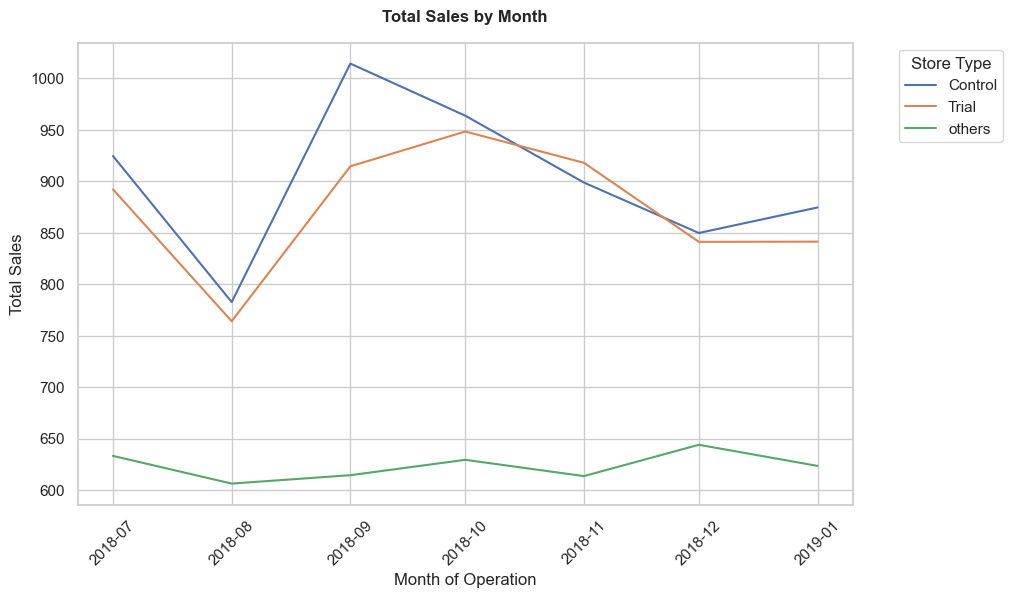

In [580]:
preTrialMeasures_sales = preTrialMeasures.copy()
preTrialMeasures_sales['Store_type'] =  preTrialMeasures_sales['STORE_NBR'].apply(
    lambda x: 'Trial' if x == 86 else ('Control' if x == 155 else 'others')
)

past_sales = preTrialMeasures_sales.groupby(['YEARMONTH', 'Store_type'])['total_sales'].mean().reset_index()

# Convert YEARMONTH to datetime format for plotting
past_sales['TransactionMonth'] = pd.to_datetime(past_sales['YEARMONTH'].astype(str) + '01', format='%Y%m%d')

# Filter data for pre-trial period
past_sales = past_sales[past_sales['YEARMONTH'] < 201903]

# Plot total sales trends
plt.figure(figsize=(10,6))
sns.lineplot(data=past_sales, x='TransactionMonth', y='total_sales', hue='Store_type')
plt.title('Total Sales by Month')
plt.xlabel('Month of Operation')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.legend(title='Store Type')
# Move the legend outside the plot
plt.legend(title='Store Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

### Visualizing Customer Trends Before the Trial  
Similar to sales, we analyze **customer trends** before the trial period by categorizing stores into **trial, control, and others**. The average monthly customer count for each group is computed and visualized.  

The code assigns store labels, calculates **mean customer count** for each group, and plots the trends for comparison.  


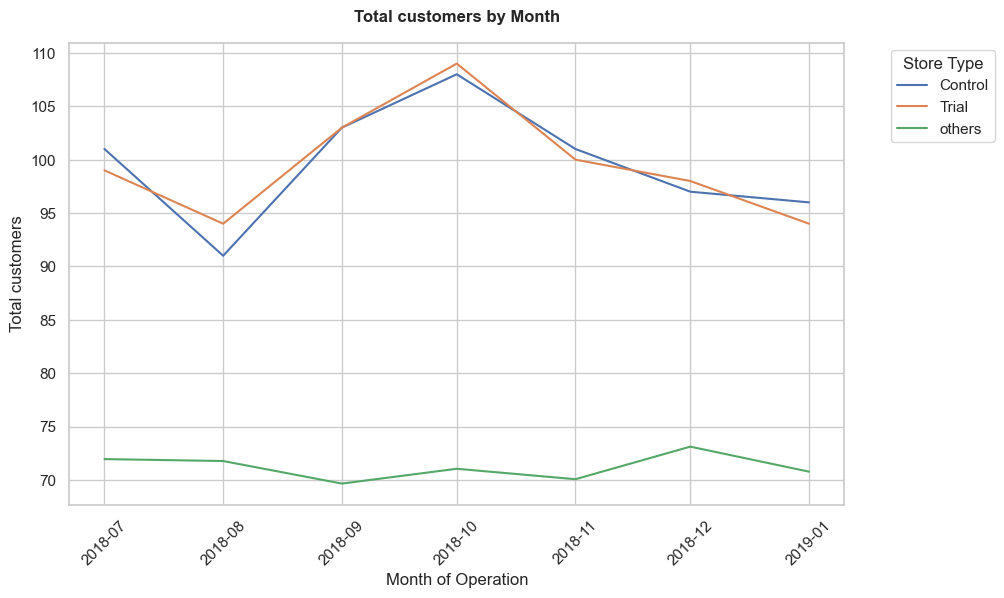

In [581]:
preTrialMeasures_cust = preTrialMeasures_sales.copy()

past_custs = preTrialMeasures_sales.groupby(['YEARMONTH', 'Store_type'])['ncustomers'].mean().reset_index()

# Convert YEARMONTH to datetime format for plotting
past_custs['TransactionMonth'] = pd.to_datetime(past_custs['YEARMONTH'].astype(str) + '01', format='%Y%m%d')

# Filter data for pre-trial period
past_custs = past_custs[past_custs['YEARMONTH'] < 201903]

# Plot total sales trends
plt.figure(figsize=(10,6))
sns.lineplot(data=past_custs, x='TransactionMonth', y='ncustomers', hue='Store_type')
plt.title('Total customers by Month')
plt.xlabel('Month of Operation')
plt.ylabel('Total customers')
plt.xticks(rotation=45)
plt.legend(title='store_type')
# Move the legend outside the plot
plt.legend(title='Store Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

### **Validation of Control Store Selection**  

The visual analysis confirms that **Store 155** closely follows the same trends as **Trial Store 86** in both **total sales** and **customer count** during the pre-trial period. This strong alignment validates Store 155 as a **suitable control store**, ensuring that any observed differences during the trial can be attributed to the intervention rather than pre-existing variations in store performance.


## **Assessing Trial Performance for Store 86**  

The trial period (**Feb 2019 – Apr 2019**) evaluates whether the intervention led to an **increase in chip sales** by comparing trial store **86** with control store **155**.  

### **Scaling Control Store Sales**  

To ensure a fair comparison, the control store’s sales are **scaled** using a pre-trial scaling factor:  

1. **Compute Scaling Factor:**  
   - Calculate **total pre-trial sales** for both trial and control stores.  
   - Derive the scaling factor by dividing trial store sales by control store sales.  

2. **Apply Scaling Factor:**  
   - Adjust control store sales by multiplying them with the scaling factor.  

This adjustment accounts for pre-existing differences, ensuring that any observed sales uplift is due to the trial intervention.


In [582]:
# Calculate total pre-trial sales for the trial store (Store 77)
pretrial_store_total_sales = preTrialMeasures[preTrialMeasures['STORE_NBR'] == 86]['total_sales'].sum()

# Calculate total pre-trial sales for the control store (Store 233)
precontrol_store_total_sales = preTrialMeasures[preTrialMeasures['STORE_NBR'] == 155]['total_sales'].sum()

# Calculate the scaling factor to align control store sales with the trial store
scaling_factor = pretrial_store_total_sales / precontrol_store_total_sales

# Filter data for the trial period (February 2019 to April 2019)
during_trial_measures = measureOverTime[
    (measureOverTime['YEARMONTH'] >= 201902) &
    (measureOverTime['YEARMONTH'] <= 201904) &
    (measureOverTime['STORE_NBR'].isin([86, 155])) 
].copy()

# Apply scaling only to the control store (233)
during_trial_measures['scaled_total_sales'] = during_trial_measures.apply(
    lambda row: row['total_sales'] * scaling_factor if row['STORE_NBR'] == 155 else row['total_sales'],
    axis=1
)

  ### Calculate Percentage Difference Between Trial and Control Sales (Trial Period)

To evaluate whether there was a significant uplift in total sales during the trial period (February 2019 to April 2019), we compute the percentage difference between the trial store’s actual sales and the scaled control store’s sales.

#### **Steps:**
1. **Extract Trial Store Sales:**  
   - Select total sales data for Store 86 (trial store) during the trial period.

2. **Extract Control Store Sales:**  
   - Select the scaled total sales data for Store 155 (control store) to ensure a fair comparison.

3. **Align Sales Data:**  
   - Merge both datasets on `YEARMONTH` to align their monthly sales performance.

4. **Compute Percentage Difference:**  
   - Calculate the percentage difference using the formula:  

     percentage_diff = ((total_sales_trial - scaled_total_sales_control) / scaled_total_sales_control) * 100  

   - This metric helps assess whether the trial had a significant impact on total sales.

5. **Display the Results:**  
   - Show the calculated percentage difference for each month during the trial period.



In [583]:
# Extract sales data for the trial store (Store 77)
trial_store_sales = during_trial_measures[during_trial_measures['STORE_NBR'] == 86][['STORE_NBR', 'YEARMONTH', 'total_sales']]

# Extract scaled sales data for the control store (Store 233)
control_store_sales = during_trial_measures[during_trial_measures['STORE_NBR'] == 155][['STORE_NBR', 'YEARMONTH', 'scaled_total_sales']]

# Merge both datasets on YEARMONTH to align their monthly performance for comparison
trial_percentage_diff = pd.merge(trial_store_sales, control_store_sales, on='YEARMONTH')

# Calculate the percentage difference between the trial store’s actual sales and the scaled control store’s sales
trial_percentage_diff['percentage_diff'] = (
    (trial_percentage_diff['total_sales'] - trial_percentage_diff['scaled_total_sales']) /
    trial_percentage_diff['scaled_total_sales']
) * 100

# Show the results
trial_percentage_diff

,STORE_NBR_x,YEARMONTH,total_sales,STORE_NBR_y,scaled_total_sales,percentage_diff
0,86,201902,913.2,155,864.522060,5.630619
1,86,201903,1026.8,155,780.320405,31.586973
2,86,201904,848.2,155,819.317024,3.525250


### Calculate Percentage Difference Between Trial and Control Sales (Pre-Trial Period)

To validate the reliability of the control store (Store 155) as a benchmark, we calculate the percentage difference in total sales between the trial store (Store 86) and the control store before the trial period. This ensures that the control store closely mirrors the trial store’s sales trends.

#### **Steps:**
1. **Filter Pre-Trial Data:**  
   - Extract sales data for both the trial and control stores before the trial period.

2. **Separate Trial and Control Sales:**  
   - Create separate datasets for Store 86 (trial store) and Store 155 (control store) with only `YEARMONTH` and `total_sales`.

3. **Scale Control Store Sales:**  
   - Multiply the control store’s total sales by the previously calculated scaling factor to align it with the trial store’s performance.

4. **Align Sales Data:**  
   - Merge both datasets on `YEARMONTH` to ensure a direct month-by-month comparison.

5. **Compute Percentage Difference:**  
   - Calculate the percentage difference between the trial store’s sales and the scaled control store’s sales.  
   - This helps confirm the suitability of Store 155 as the control store.

In [584]:
# Create a copy of the pre-trial dataset to avoid modifying the original data
pre_trial_comparison = preTrialMeasures.copy()

# Filter the dataset to include only the trial store (Store 77) and the control store (Store 233)
pre_trial_comparison = pre_trial_comparison[pre_trial_comparison['STORE_NBR'].isin([86, 155])]

# Extract sales data for the trial store (Store 77), keeping only relevant columns
pre_trial_store_sales = pre_trial_comparison[pre_trial_comparison['STORE_NBR'] == 86][['STORE_NBR', 'YEARMONTH', 'total_sales']]

# Extract sales data for the control store (Store 233), keeping only relevant columns
pre_control_store_sales = pre_trial_comparison[pre_trial_comparison['STORE_NBR'] == 155][['STORE_NBR', 'YEARMONTH', 'total_sales']]

# Scale the control store's total sales using the previously computed scaling factor
# This aligns the control store's performance with the trial store's pre-trial sales
pre_control_store_sales['scaled_sales'] = pre_control_store_sales['total_sales'] * scaling_factor

# Merge the trial store and control store sales data on YEARMONTH
# This allows us to directly compare their monthly sales performance
pre_trial_percentage_diff = pd.merge(pre_trial_store_sales, pre_control_store_sales, on='YEARMONTH')

# Calculate the percentage difference in sales between the trial store and the scaled control store
# Formula: (Total Sales of Trial Store - Scaled Sales of Control Store) / Scaled Sales of Control Store
pre_trial_percentage_diff['percent_diff'] = (
    abs(pre_trial_percentage_diff['total_sales_x'] - pre_trial_percentage_diff['scaled_sales']) /
    pre_trial_percentage_diff['scaled_sales']
) * 100

# Display the percentage difference results
pre_trial_percentage_diff


,STORE_NBR_x,YEARMONTH,total_sales_x,STORE_NBR_y,total_sales_y,scaled_sales,percent_diff
0,86,201807,892.20,155,924.6,896.922236,0.526493
1,86,201808,764.05,155,782.7,759.269991,0.629553
2,86,201809,914.60,155,1014.4,984.034086,7.056065
3,86,201810,948.40,155,963.8,934.948790,1.438711
4,86,201811,918.00,155,898.8,871.894555,5.287961
5,86,201812,841.20,155,849.8,824.361363,2.042628
6,86,201901,841.40,155,874.6,848.418979,0.827301


## Hypothesis Testing for Trial Period Significance  

### **Objective**  
We aim to determine whether the observed uplift in trial store sales is beyond the natural variation seen before the trial period.

### **Approach**  

1. **Calculate Standard Deviation of Pre-Trial Percentage Difference**  
   - Compute the standard deviation (σ) of the percentage difference in total sales between the trial and control stores during the pre-trial period.  
   - This helps measure how much variation normally exists between the two stores.

2. **Set Degrees of Freedom**  
   - Since we have 7 months of pre-trial data, the degrees of freedom (df) is calculated as:  
     - **df = Number of months - 1 = 7 - 1 = 6**

3. **Formulate the Null Hypothesis (H₀)**  
   - The null hypothesis states that there is **no significant difference** between the trial store (86) and control store (155).  
   - In other words, any observed difference is due to random variation rather than the trial intervention.

4. **Calculate t-Values**  
   - For each month in the trial period, compute the t-value using the formula:  
     - **t-value = (Observed Percentage Difference) / (Standard Deviation of Pre-Trial Percentage Difference)**  

5. **Determine Critical t-Value**  
   - For a **95% confidence level** and **6 degrees of freedom**, obtain the critical t-value from the t-distribution table.  
   - If the computed t-value exceeds this critical value, reject the null hypothesis and conclude that the difference is statistically significant.  

This statistical test ensures that the trial's impact is measured rigorously and not mistaken for normal fluctuations in sales.


In [585]:
import numpy as np
import scipy.stats as stats

# Calculate the standard deviation of the percentage difference in the pre-trial period
# This measures the typical variation between the trial and control stores before the trial
std_dev_percentage = np.std(pre_trial_percentage_diff['percent_diff'], ddof=1)  # ddof=1 for sample standard deviation

# Calculate the degrees of freedom (number of pre-trial months - 1)
degrees_of_freedom = len(pre_trial_percentage_diff) - 1

# Null hypothesis: There is no significant difference between the trial and control stores' sales
# Compute t-values for the trial period to check if the observed difference is statistically significant
trial_percentage_diff['t_value'] = (trial_percentage_diff['percentage_diff'] - 0) / std_dev_percentage

# Determine the critical t-value for a 95% confidence level with the given degrees of freedom
# If a t-value exceeds this critical value, we reject the null hypothesis
critical_t_value = stats.t.ppf(0.975, degrees_of_freedom)  # Two-tailed test (0.975 for 95% CI)

# Print the results for reference
print(f"Standard Deviation: {std_dev_percentage}")
print(f"Degrees of Freedom: {degrees_of_freedom}")
print(f"Critical t-value (95% CI): {critical_t_value}")

# Display the trial period sales percentage difference along with the calculated t-values
print(trial_percentage_diff[['YEARMONTH', 'percentage_diff', 't_value']])

Standard Deviation: 2.583395285477237
Degrees of Freedom: 6
Critical t-value (95% CI): 2.4469118511449692
   YEARMONTH  percentage_diff    t_value
0     201902         5.630619   2.179542
1     201903        31.586973  12.226922
2     201904         3.525250   1.364580


The t-test results indicate that the sales uplift in the trial store was **statistically significant** in **March 2019** (**t = 12.23**, exceeding the critical t-value of **2.45** at the 95% confidence level). This suggests that the increase in sales during this month is unlikely due to random variation and is instead attributable to the trial intervention.  

However, for **February 2019** (**t = 2.18**) and **April 2019** (**t = 1.36**), the t-values do **not** exceed the critical threshold. This implies that the sales differences in these months are **not statistically significant**, meaning the observed changes could be due to normal fluctuations rather than the trial effect.  

Overall, these results suggest that the trial had a **significant positive impact on sales in March**, but the effects in February and April were not strong enough to be considered statistically significant.  


## **Visualizing Sales Performance with Confidence Intervals**

#### **Objective**  
The purpose of this step is to visualize the total sales of:  
- **Trial store**  
- **Control store**  
- **95th percentile confidence interval of control store sales**  
- **5th percentile confidence interval of control store sales**  

This visualization helps assess **whether the trial store's sales during the trial period significantly deviate from the control store's expected range**.

#### **Approach**  
1. **Prepare the Data**  
   - Extract sales data for the **trial store** and **control store**.  
   - Compute **95th and 5th percentile confidence intervals** for control store sales using the **mean ± 2 × standard deviation** approach.  

2. **Format the Date**  
   - Convert `YEARMONTH` into a **datetime format** for proper plotting.  
   - Reformat the date into a **Month-Year format (e.g., "Feb 2019")** for clarity.  

3. **Visualize the Data**  
   - Plot the **total sales of the trial store and control store**.  
   - Add the **confidence interval bands** (95th and 5th percentile lines).  
   - Highlight the **trial period** to observe if the trial store sales exceed expectations.  

This visualization will help determine if the trial store sales **fall outside the expected range** based on historical patterns, providing a graphical confirmation of the statistical test results.


In [586]:
# Create a copy of the relevant columns from during_trial_measures
during_trial_sales_cf = during_trial_measures[['STORE_NBR', 'YEARMONTH', 'total_sales']].copy()

# Assign store type: Label 'Trial' for Store 77, otherwise 'Control'
during_trial_sales_cf['Store_type'] = during_trial_sales_cf['STORE_NBR'].apply(
    lambda x: 'Trial' if x == 86 else 'Control'
)

# Calculate the confidence interval multiplier (Convert percentage standard deviation to decimal)
multiplier = 2 * (std_dev_percentage / 100)

# Create a DataFrame for the 95th percentile confidence interval of control store sales
controlsales_95 = during_trial_sales_cf[during_trial_sales_cf['Store_type'] == 'Control'].copy()
# Increase total sales by the confidence interval multiplier (mean + 2 * std dev)
controlsales_95['total_sales'] = during_trial_sales_cf['total_sales'] * (1 + multiplier)
# Label it as the 95th percentile confidence interval
controlsales_95['Store_type'] = 'Control 95th % confidence interval'

# Create a DataFrame for the 5th percentile confidence interval of control store sales
controlsales_5 = during_trial_sales_cf[during_trial_sales_cf['Store_type'] == 'Control'].copy()
# Decrease total sales by the confidence interval multiplier (mean - 2 * std dev)
controlsales_5['total_sales'] = during_trial_sales_cf['total_sales'] * (1 - multiplier)
# Label it as the 5th percentile confidence interval
controlsales_5['Store_type'] = 'Control 5th % confidence interval'

# Combine all datasets into a single DataFrame for visualization
trial_assessment = pd.concat([during_trial_sales_cf, controlsales_95, controlsales_5])

# Convert YEARMONTH column to datetime format for accurate plotting
trial_assessment['YEARMONTH'] = pd.to_datetime(trial_assessment['YEARMONTH'], format='%Y%m')

# Create a new column to display the date in "Month Year" format (e.g., "Feb 2019")
trial_assessment['TransactionMonth'] = trial_assessment['YEARMONTH'].dt.strftime('%b %Y')


**Visualizing the Data** 

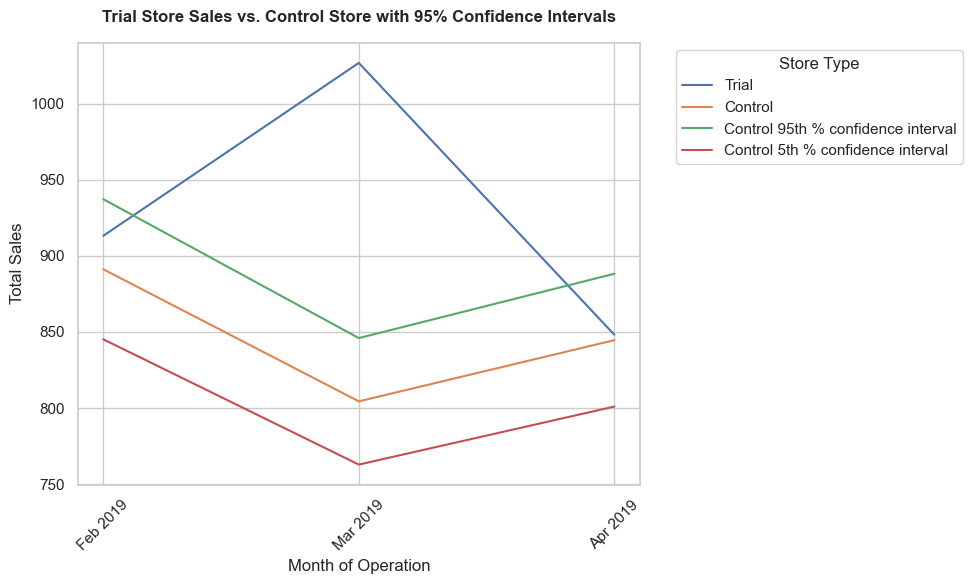

In [587]:
# Set the figure size for better readability
plt.figure(figsize=(10,6))

# Create a line plot for total sales over time, colored by store type
sns.lineplot(data=trial_assessment, x='TransactionMonth', y='total_sales', hue='Store_type')

# Add a title to the plot
plt.title('Trial Store Sales vs. Control Store with 95% Confidence Intervals')

# Label the x-axis
plt.xlabel('Month of Operation')

# Label the y-axis
plt.ylabel('Total Sales')

# Add a legend to indicate store types (Trial, Control, and Confidence Intervals)
plt.legend(title='Store Type')

# Move the legend outside the plot for better visibility
plt.legend(title='Store Type', bbox_to_anchor=(1.05, 1), loc='upper left')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout to prevent overlapping labels
plt.tight_layout()

# Display the plot
plt.show()


The results indicate that the trial in store 86 is generally in line with its control store during the trial period. However, in one of the three trial months, the trial store's performance falls outside the 5% to 95% confidence interval of the control store, suggesting a temporary deviation from expected sales patterns.


## Assessing Customer Trends with Confidence Intervals  

To evaluate whether the trial store experienced a significant change in customer count during the trial period, we will follow the same approach as total sales.  

1. **Scale Pre-Trial Control Store Customers**  
   - Adjust the number of customers in the control store to match the trial store before the trial period.  
   
2. **Calculate  Differences**  
   - Compute the difference between the trial store and scaled control store customers.  

3. **Determine Confidence Intervals**  
   - Compute the standard deviation of percentage differences in customer counts during the pre-trial period.  
   - Define the 95th and 5th percentile confidence intervals (mean ± 2 * standard deviation).  

4. **Visualize the Results**  
   - Plot the trial store's customer count alongside the control store and its confidence intervals.  
   - If the trial store's customer count falls outside the confidence intervals, it suggests a significant change during the trial period.  

This approach allows us to visually assess whether the trial store had a notable increase or decrease in customers.  

In [588]:
scaling_factor_cust = (
    preTrialMeasures[preTrialMeasures['STORE_NBR'] == 86]['ncustomers'].sum() /
    preTrialMeasures[preTrialMeasures['STORE_NBR'] == 155]['ncustomers'].sum()
)

# Extract customer data for the trial store (Store 77), keeping only relevant columns
pre_trial_store_cust = pre_trial_comparison[pre_trial_comparison['STORE_NBR'] == 86][['STORE_NBR', 'YEARMONTH', 'ncustomers']]

# Extract customer data for the control store (Store 233), keeping only relevant columns
pre_control_store_cust = pre_trial_comparison[pre_trial_comparison['STORE_NBR'] == 155][['STORE_NBR', 'YEARMONTH', 'ncustomers']]

# Scale the control store's total sales using the previously computed scaling factor
# This aligns the control store's performance with the trial store's pre-trial sales
pre_control_store_cust['scaled_cust'] = pre_control_store_cust['ncustomers'] * scaling_factor_cust

# Merge the trial store and control store sales data on YEARMONTH
# This allows us to directly compare their monthly sales performance
pre_trial_diff_cust = pd.merge(pre_trial_store_cust,pre_control_store_cust,on='YEARMONTH')

# Calculate the percentage difference in sales between the trial store and the scaled control store
# Formula: |(Total Sales of Trial Store - Scaled Sales of Control Store)| / Scaled Sales of Control Store
pre_trial_diff_cust['cust_diff'] = (
    abs(pre_trial_diff_cust['ncustomers_x'] - pre_trial_diff_cust['scaled_cust']) /
    pre_trial_diff_cust['scaled_cust']
) 

# Display the percentage difference results
pre_trial_diff_cust

,STORE_NBR_x,YEARMONTH,ncustomers_x,STORE_NBR_y,ncustomers_y,scaled_cust,cust_diff
0,86,201807,99,155,101,101.0,0.019802
1,86,201808,94,155,91,91.0,0.032967
2,86,201809,103,155,103,103.0,0.000000
3,86,201810,109,155,108,108.0,0.009259
4,86,201811,100,155,101,101.0,0.009901
5,86,201812,98,155,97,97.0,0.010309
6,86,201901,94,155,96,96.0,0.020833


In [589]:
# Calculate the standard deviation of the percentage difference in customer count before the trial
std_dev_cust = np.std(pre_trial_diff_cust['cust_diff'], ddof=1) 

# Create a copy of the relevant columns from during_trial_measures for customer analysis
during_trial_cust_cf = during_trial_measures[['STORE_NBR', 'YEARMONTH', 'ncustomers']].copy()

# Assign store type: Label 'Trial' for Store 77, otherwise 'Control'
during_trial_cust_cf['Store_type'] = during_trial_cust_cf['STORE_NBR'].apply(
    lambda x: 'Trial' if x == 86 else 'Control'
)

# Calculate the confidence interval multiplier (95% CI is typically mean ± 2 * std dev)
multiplier = 2 * std_dev_cust

# Create a DataFrame for the 95th percentile confidence interval of control store customers
controlcust_95 = during_trial_cust_cf[during_trial_cust_cf['Store_type'] == 'Control'].copy()
# Increase customer count by the confidence interval multiplier (mean + 2 * std dev)
controlcust_95['ncustomers'] = controlcust_95['ncustomers'] * (1 + multiplier)
# Label it as the 95th percentile confidence interval
controlcust_95['Store_type'] = 'Control 95th % confidence interval'

# Create a DataFrame for the 5th percentile confidence interval of control store customers
controlcust_5 = during_trial_cust_cf[during_trial_cust_cf['Store_type'] == 'Control'].copy()
# Decrease customer count by the confidence interval multiplier (mean - 2 * std dev)
controlcust_5['ncustomers'] = controlcust_5['ncustomers'] * (1 - multiplier)
# Label it as the 5th percentile confidence interval
controlcust_5['Store_type'] = 'Control 5th % confidence interval'

# Combine all datasets into a single DataFrame for visualization
trial_cust_assessment = pd.concat([during_trial_cust_cf, controlcust_95, controlcust_5])

# Convert YEARMONTH column to datetime format for accurate plotting
trial_cust_assessment['YEARMONTH'] = pd.to_datetime(trial_cust_assessment['YEARMONTH'], format='%Y%m')

# Create a new column to display the date in "Month Year" format (e.g., "Feb 2019")
trial_cust_assessment['TransactionMonth'] = trial_cust_assessment['YEARMONTH'].dt.strftime('%b %Y')


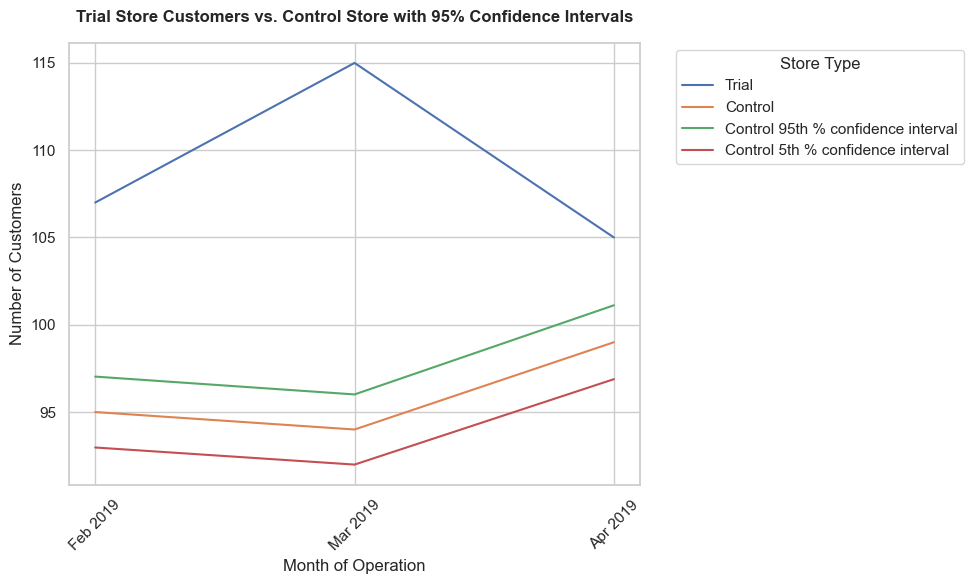

In [590]:
# Set the figure size for better readability
plt.figure(figsize=(10,6))

# Create a line plot for number of customers over time, colored by store type
sns.lineplot(data=trial_cust_assessment, x='TransactionMonth', y='ncustomers', hue='Store_type')

# Add a title to the plot
plt.title('Trial Store Customers vs. Control Store with 95% Confidence Intervals')

# Label the x-axis
plt.xlabel('Month of Operation')

# Label the y-axis
plt.ylabel('Number of Customers')

# Add a legend to indicate store types (Trial, Control, and Confidence Intervals)
plt.legend(title='Store Type')

# Move the legend outside the plot for better visibility
plt.legend(title='Store Type', bbox_to_anchor=(1.05, 1), loc='upper left')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout to prevent overlapping labels
plt.tight_layout()

# Display the plot
plt.show()


It looks like the number of customers is significantly higher in all of the three
months. This seems to suggest that the trial had a significant impact on increasing
the number of customers in trial store 86 but as we saw, sales were not
significantly higher.

### **Findings**  

The results indicate that the trial in Store 86 had a **significant impact on customer count** but a **limited effect on total sales** compared to its control store.  

- The **number of customers was significantly higher** in all three trial months, suggesting that the trial successfully attracted more customers.  
- However, **sales exceeded the 5% to 95% confidence interval of the control store in only one of the three trial months**, indicating that while more customers visited the store, their spending did not increase proportionally.  
- The **t-test results** reinforce this finding, showing a **statistically significant increase in sales only in March**, while February and April remained within expected variations.  

Overall, the trial intervention appears to have been **effective in increasing foot traffic**, but its impact on overall sales was **not consistently significant** throughout the trial period.


## Trial Store 88


### **Applying the Same Methodology to Another Trial-Control Store Pair (Trial Store 88)**  

Having completed the analysis for **Trial Store 77** and **Trial Store 86**, we now move forward with evaluating **Trial Store 88** using the same methodology.  

The approach follows the same steps used for Store 77:  
1. **Identifying a suitable control store** for Store 88.  
2. **Scaling the control store's sales and customer count** to match the pre-trial period.  
3. **Calculating percentage differences** and deriving confidence intervals.  
4. **Visualizing the results** to determine whether the trial store's performance significantly deviates from the control store.  

For detailed explanations of each step, please refer to the analysis of **Trial Store 77**. Below is the implementation of these steps for the next trial-control store pair. 


## Finding Control Stores for Trial Store 88  

To identify a suitable control store for **Trial Store 88**, we evaluate store similarity based on two key metrics:  

1. **Correlation Scores**: Measures how closely the trends in total sales and number of customers match those of Trial Store 88.  
2. **Magnitude Scores**: Measures how similar the total sales and number of customers are in absolute size compared to Trial Store 88.  

We use the **function created earlier** to compute these metrics and determine the best control store.  

The function calculates the following metrics:  
- **`corr_nSales`**: Correlation of total sales between stores.  
- **`corr_nCustomers`**: Correlation of number of customers between stores.  
- **`magnitude_nSales`**: Magnitude similarity in total sales.  
- **`magnitude_nCustomers`**: Magnitude similarity in number of customers.  


In [591]:
# Compute correlation scores to measure trend similarity
corr_nSales = calculate_correlation(preTrialMeasures, 'total_sales', [88])
corr_nCustomers = calculate_correlation(preTrialMeasures, 'ncustomers', [88])

# Compute magnitude scores to measure size similarity
magnitude_nSales = calculate_magnitude_distance(preTrialMeasures, 'total_sales', 88)
magnitude_nCustomers = calculate_magnitude_distance(preTrialMeasures, 'ncustomers', 88)

# Display results
print("Correlation of Total Sales:")
display(corr_nSales.head())

print("\nCorrelation of Number of Customers:")
display(corr_nCustomers.head())

print("\nMagnitude Distance for Total Sales:")
display(magnitude_nSales.head())

print("\nMagnitude Distance for Number of Customers:")
display(magnitude_nCustomers.head())

Correlation of Total Sales:


,Trial_Store,Control_Store,Correlation
0,88,1,0.813636
1,88,2,-0.067927
2,88,3,-0.507847
3,88,4,-0.745566
4,88,5,0.190330



Correlation of Number of Customers:


,Trial_Store,Control_Store,Correlation
0,88,1,0.305334
1,88,2,-0.452379
2,88,3,0.522884
3,88,4,-0.361503
4,88,5,-0.025320



Magnitude Distance for Total Sales:


,STORE_NBR,magnitude_score
0,1,0.190486
1,2,0.164328
2,3,0.811969
3,4,0.903466
4,5,0.631124



Magnitude Distance for Number of Customers:


,STORE_NBR,magnitude_score
0,1,0.376523
1,2,0.326689
2,3,0.849391
3,4,0.928018
4,5,0.746401


### Calculate Control Store Metrics and Combine Scores  

We combine **correlation** and **magnitude scores** into a **composite score (`c_score`)** to identify the best control store for **Trial Store 88**.  

#### **Steps:**  
1. **Merge Tables** on `STORE_NBR` and `Control_Store`.  
2. **Compute `c_score`** as the average of correlation and magnitude scores.  
3. **Sort by `c_score`** to find the most suitable control store.  


In [592]:
# Combine magnitude and correlation scores for total sales
combined_index_sales = magnitude_nSales.merge(
    corr_nSales,
    left_on='STORE_NBR',        # Matching store numbers
    right_on='Control_Store',   
    suffixes=('', '_trial')
)

# Calculate combined similarity score for sales
combined_index_sales['sales_c_score'] = (
    0.5 * combined_index_sales['Correlation'] + 
    0.5 * combined_index_sales['magnitude_score']
)

# Sort stores by combined score in descending order
combined_index_sales = combined_index_sales.sort_values(by='sales_c_score', ascending=False)

# Combine magnitude and correlation scores for customer count
combined_index_cust = magnitude_nCustomers.merge(
    corr_nCustomers,
    left_on='STORE_NBR',
    right_on='Control_Store',
    suffixes=('', '_trial')
)

# Calculate combined similarity score for customer count
combined_index_cust['cust_c_score'] = (
    0.5 * combined_index_cust['Correlation'] + 
    0.5 * combined_index_cust['magnitude_score']
)

# Sort stores by combined score in descending order
combined_index_cust = combined_index_cust.sort_values(by='cust_c_score', ascending=False)

# Display results
print("Top Control Stores Based on Sales Similarity:")
display(combined_index_sales.head())

print("\nTop Control Stores Based on Customer Count Similarity:")
display(combined_index_cust.head())


Top Control Stores Based on Sales Similarity:


,STORE_NBR,magnitude_score,Trial_Store,Control_Store,Correlation,sales_c_score
116,125,0.860721,88,125,0.624109,0.742415
193,203,0.953160,88,203,0.508001,0.730581
84,91,0.680758,88,91,0.776688,0.728723
169,178,0.712595,88,178,0.731857,0.722226
6,7,0.790442,88,7,0.649657,0.720049



Top Control Stores Based on Customer Count Similarity:


,STORE_NBR,magnitude_score,Trial_Store,Control_Store,Correlation,cust_c_score
224,237,0.987818,88,237,0.947326,0.967572
169,178,0.828350,88,178,0.939466,0.883908
65,69,0.874862,88,69,0.815792,0.845327
105,113,0.792913,88,113,0.862632,0.827772
110,119,0.787375,88,119,0.775468,0.781422


### Merge Sales and Customer Combined Scores  

We merge **sales and customer scores** into a **final control score (`final_c_score`)** to ensure both factors contribute equally to selecting the best control store.  

#### **Steps:**  
1. **Merge `combined_index_sales` and `combined_index_cust`** on `STORE_NBR`.  
2. **Compute `final_c_score`** as the average of sales and customer scores.  
3. **Sort by `final_c_score`** to determine the best control store.  


In [593]:
# Merge sales and customer combined scores into a single table
# This ensures both metrics are considered when selecting the best control store
final_combined_index = combined_index_sales.merge(
    combined_index_cust,   # Merge with customer-based scores
    on='STORE_NBR',        # Match stores by store number
    suffixes=('_sales', '_cust')  # Add suffixes to distinguish columns
)

# Calculate the final control score as the average of sales and customer scores
final_combined_index['final_c_score'] = (
    0.5 * final_combined_index['sales_c_score'] +  # Weight for sales similarity
    0.5 * final_combined_index['cust_c_score']     # Weight for customer similarity
)

# Sort stores in descending order to find the best control store
final_combined_index = final_combined_index.sort_values(by='final_c_score', ascending=False)

# Display the final table
final_combined_index[['STORE_NBR','final_c_score']].head()

,STORE_NBR,final_c_score
3,178,0.803067
10,237,0.800555
21,69,0.716173
19,113,0.712914
5,201,0.701836


### Final Decision on Control Store Selection  

The final combined index shows that **stores 178 and 237** have nearly identical scores. Since the numerical results alone do not provide a clear distinction, we will visualize both stores for further validation.  

### **1. Visualizing Total Sales Over Time**  

We will compare the **total sales trends** of the trial store, the control store, and other stores before the trial period to ensure their sales patterns align.  

#### **Steps:**  

1. **Categorize Stores:**  
   - Label **Store 88** as the **'Trial'** store.  
   - Label **Store 178 and Store 237** as the **'Control'** stores.  
   - Label all other stores as **'Other stores'**.  

2. **Aggregate Data:**  
   - Compute the **average total sales per month** for each store type.  

3. **Format Dates:**  
   - Convert `YEARMONTH` into a **datetime format** for plotting.  

4. **Filter Data:**  
   - Keep only the **pre-trial period** for analysis (exclude the trial period).  

5. **Plot the Data:**  
   - Generate a **line plot** to visualize **total sales over time** by store type.  


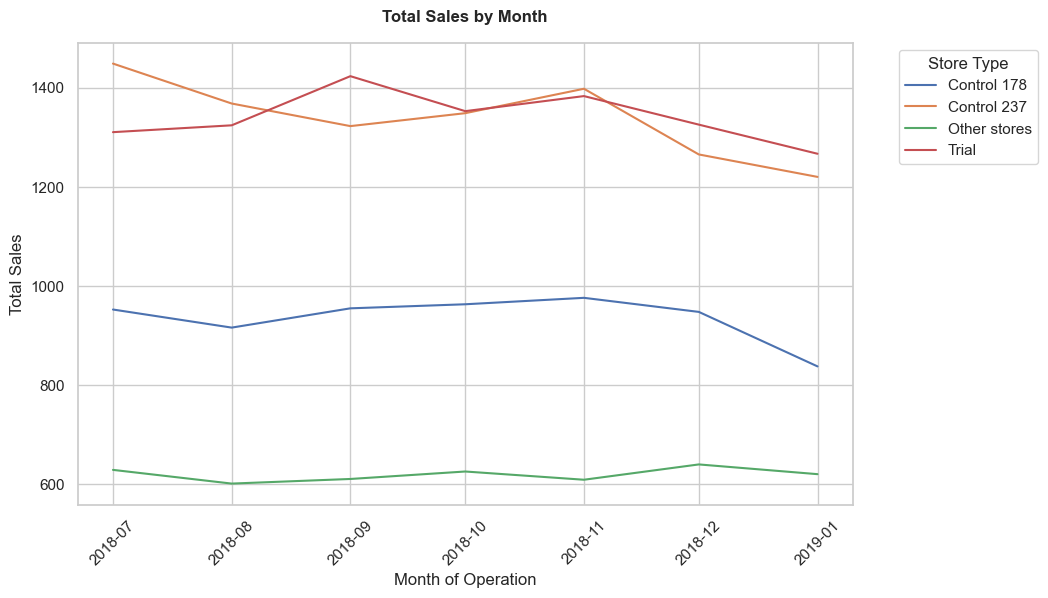

In [594]:
preTrialMeasures_sales = preTrialMeasures.copy()
preTrialMeasures_sales['Store_type'] =  preTrialMeasures_sales['STORE_NBR'].apply(
    lambda x: 'Trial' if x == 88 else ('Control 178' if x == 178 else ('Control 237' if x == 237 else 'Other stores'))
)

past_sales = preTrialMeasures_sales.groupby(['YEARMONTH', 'Store_type'])['total_sales'].mean().reset_index()

# Convert YEARMONTH to datetime format for plotting
past_sales['TransactionMonth'] = pd.to_datetime(past_sales['YEARMONTH'].astype(str) + '01', format='%Y%m%d')

# Filter data for pre-trial period
past_sales = past_sales[past_sales['YEARMONTH'] < 201903]

# Plot total sales trends
plt.figure(figsize=(10,6))
sns.lineplot(data=past_sales, x='TransactionMonth', y='total_sales', hue='Store_type')
plt.title('Total Sales by Month')
plt.xlabel('Month of Operation')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.legend(title='Store Type')
# Move the legend outside the plot
plt.legend(title='Store Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

### **Visualizing Total Customers Over Time**  

We’ll compare the **total customers** of the trial store, the control store, and the other stores to see if their trends align closely before the trial period. 

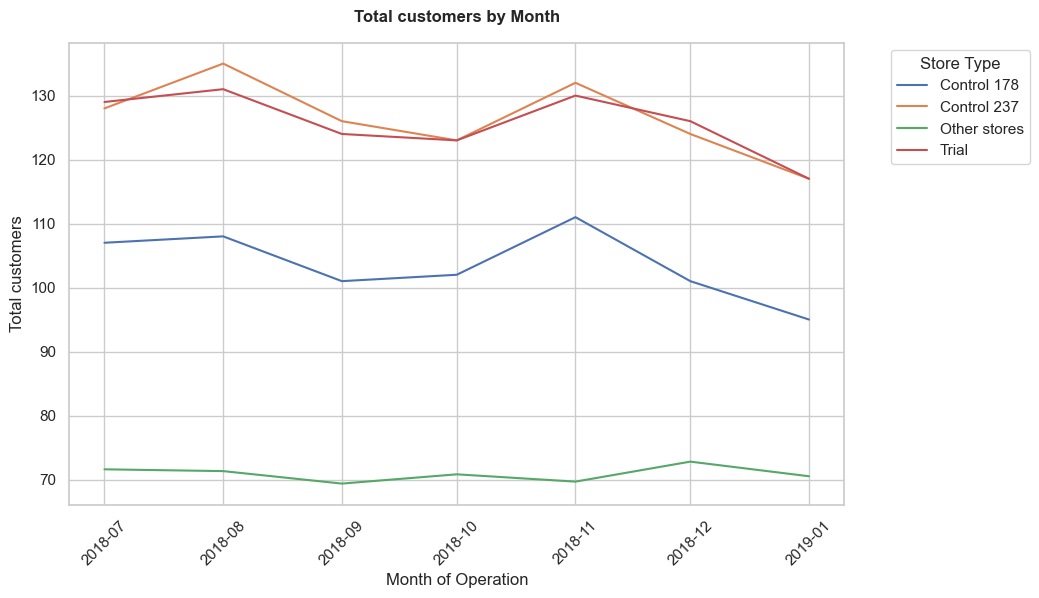

In [595]:
preTrialMeasures_cust = preTrialMeasures_sales.copy()

past_custs = preTrialMeasures_sales.groupby(['YEARMONTH', 'Store_type'])['ncustomers'].mean().reset_index()

# Convert YEARMONTH to datetime format for plotting
past_custs['TransactionMonth'] = pd.to_datetime(past_custs['YEARMONTH'].astype(str) + '01', format='%Y%m%d')

# Filter data for pre-trial period
past_custs = past_custs[past_custs['YEARMONTH'] < 201903]

# Plot total sales trends
plt.figure(figsize=(10,6))
sns.lineplot(data=past_custs, x='TransactionMonth', y='ncustomers', hue='Store_type')
plt.title('Total customers by Month')
plt.xlabel('Month of Operation')
plt.ylabel('Total customers')
plt.xticks(rotation=45)
plt.legend(title='store_type')
# Move the legend outside the plot
plt.legend(title='Store Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

### **Validation Through Visuals**  

From the visual analysis:  

- **Store 178** shows a strong correlation with the trial store in terms of **trend similarity**.  
- **Store 237**, however, aligns better in terms of **magnitude**, meaning the absolute sales and customer numbers are more comparable to **Store 88**.  

Since magnitude plays a crucial role in ensuring the trial impact is measured against a store of similar size, we select **Store 237** as the final control store.  


## **Assessment of Trial Performance**  

The trial period runs from **February 2019 to April 2019**. To determine whether the trial led to an **increase in chip sales**, we need to compare the sales of the **trial store (88)** with those of the **control store (237)**.  

### **Scaling Control Store Sales**  

Before evaluating performance, we must **scale the control store’s sales** to align with the trial store’s pre-trial sales. This ensures a fair comparison by accounting for differences in sales levels before the trial.  

1. **Calculate Scaling Factor:**  
   - Compute **total pre-trial sales** for both the **trial store (88)** and **control store (237)** (before February 2019).  
   - Compute the **scaling factor** by dividing total trial store sales by total control store sales for the pre-trial period.  

2. **Apply Scaling Factor:**  
   - Adjust the control store's total sales by multiplying them with the **scaling factor**.  

By scaling the control store’s sales, we ensure that any observed uplift during the trial period is due to the **trial intervention** rather than pre-existing differences between the stores.  


In [596]:
# Calculate total pre-trial sales for the trial store (Store 77)
pretrial_store_total_sales = preTrialMeasures[preTrialMeasures['STORE_NBR'] == 88]['total_sales'].sum()

# Calculate total pre-trial sales for the control store (Store 233)
precontrol_store_total_sales = preTrialMeasures[preTrialMeasures['STORE_NBR'] == 237]['total_sales'].sum()

# Calculate the scaling factor to align control store sales with the trial store
scaling_factor = pretrial_store_total_sales / precontrol_store_total_sales

# Filter data for the trial period (February 2019 to April 2019)
during_trial_measures = measureOverTime[
    (measureOverTime['YEARMONTH'] >= 201902) &
    (measureOverTime['YEARMONTH'] <= 201904) &
    (measureOverTime['STORE_NBR'].isin([88, 237])) 
].copy()

# Apply scaling only to the control store (233)
during_trial_measures['scaled_total_sales'] = during_trial_measures.apply(
    lambda row: row['total_sales'] * scaling_factor if row['STORE_NBR'] == 237 else row['total_sales'],
    axis=1
)

### Calculate Percentage Difference Between Trial and Control Sales (Trial Period)

To evaluate whether there was a significant uplift in total sales during the trial period (February 2019 to April 2019), we compute the percentage difference between the trial store’s actual sales and the scaled control store’s sales.

#### **Steps:**
1. **Extract Trial Store Sales:**  
   - Select total sales data for Store 88 (trial store) during the trial period.

2. **Extract Control Store Sales:**  
   - Select the scaled total sales data for Store 237 (control store) to ensure a fair comparison.

3. **Align Sales Data:**  
   - Merge both datasets on `YEARMONTH` to align their monthly sales performance.

4. **Compute Percentage Difference:**  
   - Calculate the percentage difference using the formula:  

     percentage_diff = ((total_sales_trial - scaled_total_sales_control) / scaled_total_sales_control) * 100  

   - This metric helps assess whether the trial had a significant impact on total sales.

5. **Display the Results:**  
   - Show the calculated percentage difference for each month during the trial period.


In [597]:
# Extract sales data for the trial store (Store 77)
trial_store_sales = during_trial_measures[during_trial_measures['STORE_NBR'] == 88][['STORE_NBR', 'YEARMONTH', 'total_sales']]

# Extract scaled sales data for the control store (Store 233)
control_store_sales = during_trial_measures[during_trial_measures['STORE_NBR'] == 237][['STORE_NBR', 'YEARMONTH', 'scaled_total_sales']]

# Merge both datasets on YEARMONTH to align their monthly performance for comparison
trial_percentage_diff = pd.merge(trial_store_sales, control_store_sales, on='YEARMONTH')

# Calculate the percentage difference between the trial store’s actual sales and the scaled control store’s sales
trial_percentage_diff['percentage_diff'] = (
    (trial_percentage_diff['total_sales'] - trial_percentage_diff['scaled_total_sales']) /
    trial_percentage_diff['scaled_total_sales']
) * 100

# Show the results
trial_percentage_diff


,STORE_NBR_x,YEARMONTH,total_sales,STORE_NBR_y,scaled_total_sales,percentage_diff
0,88,201902,1370.2,237,1406.989143,-2.614742
1,88,201903,1477.2,237,1210.082775,22.074294
2,88,201904,1439.4,237,1206.477165,19.306029


### Calculate Percentage Difference Between Trial and Control Sales (Pre-Trial Period)

To validate the reliability of the control store (Store 237) as a benchmark, we calculate the percentage difference in total sales between the trial store (Store 88) and the control store before the trial period. This ensures that the control store closely mirrors the trial store’s sales trends.

#### **Steps:**
1. **Filter Pre-Trial Data:**  
   - Extract sales data for both the trial and control stores before the trial period.

2. **Separate Trial and Control Sales:**  
   - Create separate datasets for Store 88 (trial store) and Store 237 (control store) with only `YEARMONTH` and `total_sales`.

3. **Scale Control Store Sales:**  
   - Multiply the control store’s total sales by the previously calculated scaling factor to align it with the trial store’s performance.

4. **Align Sales Data:**  
   - Merge both datasets on `YEARMONTH` to ensure a direct month-by-month comparison.

5. **Compute Percentage Difference:**  
   - Calculate the percentage difference between the trial store’s sales and the scaled control store’s sales.  
   - This helps confirm the suitability of Store 237 as the control store.



In [598]:
# Create a copy of the pre-trial dataset to avoid modifying the original data
pre_trial_comparison = preTrialMeasures.copy()

# Filter the dataset to include only the trial store (Store 88) and the control store (Store 237)
pre_trial_comparison = pre_trial_comparison[pre_trial_comparison['STORE_NBR'].isin([88, 237])]

# Extract sales data for the trial store (Store 77), keeping only relevant columns
pre_trial_store_sales = pre_trial_comparison[pre_trial_comparison['STORE_NBR'] == 88][['STORE_NBR', 'YEARMONTH', 'total_sales']]

# Extract sales data for the control store (Store 233), keeping only relevant columns
pre_control_store_sales = pre_trial_comparison[pre_trial_comparison['STORE_NBR'] == 237][['STORE_NBR', 'YEARMONTH', 'total_sales']]

# Scale the control store's total sales using the previously computed scaling factor
# This aligns the control store's performance with the trial store's pre-trial sales
pre_control_store_sales['scaled_sales'] = pre_control_store_sales['total_sales'] * scaling_factor

# Merge the trial store and control store sales data on YEARMONTH
# This allows us to directly compare their monthly sales performance
pre_trial_percentage_diff = pd.merge(pre_trial_store_sales, pre_control_store_sales, on='YEARMONTH')

# Calculate the percentage difference in sales between the trial store and the scaled control store
# Formula: |(Total Sales of Trial Store - Scaled Sales of Control Store)| / Scaled Sales of Control Store
pre_trial_percentage_diff['percent_diff'] = (
    abs(pre_trial_percentage_diff['total_sales_x'] - pre_trial_percentage_diff['scaled_sales']) /
    pre_trial_percentage_diff['scaled_sales']
) * 100

# Display the percentage difference results
pre_trial_percentage_diff

,STORE_NBR_x,YEARMONTH,total_sales_x,STORE_NBR_y,total_sales_y,scaled_sales,percent_diff
0,88,201807,1310.0,237,1448.4,1450.657086,9.696095
1,88,201808,1323.8,237,1367.8,1369.931485,3.367430
2,88,201809,1423.0,237,1322.2,1324.260425,7.456205
3,88,201810,1352.4,237,1348.3,1350.401097,0.148023
4,88,201811,1382.8,237,1397.6,1399.777923,1.212901
5,88,201812,1325.2,237,1265.0,1266.971288,4.595898
6,88,201901,1266.4,237,1219.7,1221.600696,3.667262


## Hypothesis Testing for Trial Period Significance  

### **Objective**  
We aim to determine whether the observed uplift in trial store sales is beyond the natural variation seen before the trial period.

### **Approach**  

1. **Calculate Standard Deviation of Pre-Trial Percentage Difference**  
   - Compute the standard deviation (σ) of the percentage difference in total sales between the trial and control stores during the pre-trial period.  
   - This helps measure how much variation normally exists between the two stores.

2. **Set Degrees of Freedom**  
   - Since we have 7 months of pre-trial data, the degrees of freedom (df) is calculated as:  
     - **df = Number of months - 1 = 7 - 1 = 6**

3. **Formulate the Null Hypothesis (H₀)**  
   - The null hypothesis states that there is **no significant difference** between the trial store (88) and control store (237).  
   - In other words, any observed difference is due to random variation rather than the trial intervention.

4. **Calculate t-Values**  
   - For each month in the trial period, compute the t-value using the formula:  
     - **t-value = (Observed Percentage Difference) / (Standard Deviation of Pre-Trial Percentage Difference)**  

5. **Determine Critical t-Value**  
   - For a **95% confidence level** and **6 degrees of freedom**, obtain the critical t-value from the t-distribution table.  
   - If the computed t-value exceeds this critical value, reject the null hypothesis and conclude that the difference is statistically significant.  

This statistical test ensures that the trial's impact is measured rigorously and not mistaken for normal fluctuations in sales.


In [599]:
import numpy as np
import scipy.stats as stats

# Calculate the standard deviation of the percentage difference in the pre-trial period
# This measures the typical variation between the trial and control stores before the trial
std_dev_percentage = np.std(pre_trial_percentage_diff['percent_diff'], ddof=1)  # ddof=1 for sample standard deviation

# Calculate the degrees of freedom (number of pre-trial months - 1)
degrees_of_freedom = len(pre_trial_percentage_diff) - 1

# Null hypothesis: There is no significant difference between the trial and control stores' sales
# Compute t-values for the trial period to check if the observed difference is statistically significant
trial_percentage_diff['t_value'] = (trial_percentage_diff['percentage_diff'] - 0) / std_dev_percentage

# Determine the critical t-value for a 95% confidence level with the given degrees of freedom
# If a t-value exceeds this critical value, we reject the null hypothesis
critical_t_value = stats.t.ppf(0.975, degrees_of_freedom)  # Two-tailed test (0.975 for 95% CI)

# Print the results for reference
print(f"Standard Deviation: {std_dev_percentage}")
print(f"Degrees of Freedom: {degrees_of_freedom}")
print(f"Critical t-value (95% CI): {critical_t_value}")

# Display the trial period sales percentage difference along with the calculated t-values
print(trial_percentage_diff[['YEARMONTH', 'percentage_diff', 't_value']])


Standard Deviation: 3.3467867303078798
Degrees of Freedom: 6
Critical t-value (95% CI): 2.4469118511449692
   YEARMONTH  percentage_diff   t_value
0     201902        -2.614742 -0.781270
1     201903        22.074294  6.595668
2     201904        19.306029  5.768527


We observe that the t-values for **March (6.60)** and **April (5.77)** exceed the critical t-value of **2.45** at the **95% confidence level**, indicating that the increase in sales in the trial store during these months is **statistically significant**. This suggests that the uplift in sales observed in the trial store is **unlikely due to random variation** and is instead **attributable to the trial intervention**.  

Conversely, since the **t-value for February (-0.78)** does not exceed the critical threshold, we infer that the sales difference in February is **not statistically significant**, meaning the observed change could be due to **normal fluctuations rather than the trial effect**.  

Overall, these results support the hypothesis that the **intervention had a positive impact on sales, particularly in March and April**.


## **Visualizing Sales Performance with Confidence Intervals**

#### **Objective**  
The purpose of this step is to visualize the total sales of:  
- **Trial store**  
- **Control store**  
- **95th percentile confidence interval of control store sales**  
- **5th percentile confidence interval of control store sales**  

This visualization helps assess **whether the trial store's sales during the trial period significantly deviate from the control store's expected range**.

#### **Approach**  
1. **Prepare the Data**  
   - Extract sales data for the **trial store** and **control store**.  
   - Compute **95th and 5th percentile confidence intervals** for control store sales using the **mean ± 2 × standard deviation** approach.  

2. **Format the Date**  
   - Convert `YEARMONTH` into a **datetime format** for proper plotting.  
   - Reformat the date into a **Month-Year format (e.g., "Feb 2019")** for clarity.  

3. **Visualize the Data**  
   - Plot the **total sales of the trial store and control store**.  
   - Add the **confidence interval bands** (95th and 5th percentile lines).  
   - Highlight the **trial period** to observe if the trial store sales exceed expectations.  

This visualization will help determine if the trial store sales **fall outside the expected range** based on historical patterns, providing a graphical confirmation of the statistical test results.


In [600]:
# Create a copy of the relevant columns from during_trial_measures
during_trial_sales_cf = during_trial_measures[['STORE_NBR', 'YEARMONTH', 'total_sales']].copy()

# Assign store type: Label 'Trial' for Store 77, otherwise 'Control'
during_trial_sales_cf['Store_type'] = during_trial_sales_cf['STORE_NBR'].apply(
    lambda x: 'Trial' if x == 88 else 'Control'
)

# Calculate the confidence interval multiplier (Convert percentage standard deviation to decimal)
multiplier = 2 * (std_dev_percentage / 100)

# Create a DataFrame for the 95th percentile confidence interval of control store sales
controlsales_95 = during_trial_sales_cf[during_trial_sales_cf['Store_type'] == 'Control'].copy()
# Increase total sales by the confidence interval multiplier (mean + 2 * std dev)
controlsales_95['total_sales'] = during_trial_sales_cf['total_sales'] * (1 + multiplier)
# Label it as the 95th percentile confidence interval
controlsales_95['Store_type'] = 'Control 95th % confidence interval'

# Create a DataFrame for the 5th percentile confidence interval of control store sales
controlsales_5 = during_trial_sales_cf[during_trial_sales_cf['Store_type'] == 'Control'].copy()
# Decrease total sales by the confidence interval multiplier (mean - 2 * std dev)
controlsales_5['total_sales'] = during_trial_sales_cf['total_sales'] * (1 - multiplier)
# Label it as the 5th percentile confidence interval
controlsales_5['Store_type'] = 'Control 5th % confidence interval'

# Combine all datasets into a single DataFrame for visualization
trial_assessment = pd.concat([during_trial_sales_cf, controlsales_95, controlsales_5])

# Convert YEARMONTH column to datetime format for accurate plotting
trial_assessment['YEARMONTH'] = pd.to_datetime(trial_assessment['YEARMONTH'], format='%Y%m')

# Create a new column to display the date in "Month Year" format (e.g., "Feb 2019")
trial_assessment['TransactionMonth'] = trial_assessment['YEARMONTH'].dt.strftime('%b %Y')


**Visualizing the Data** 

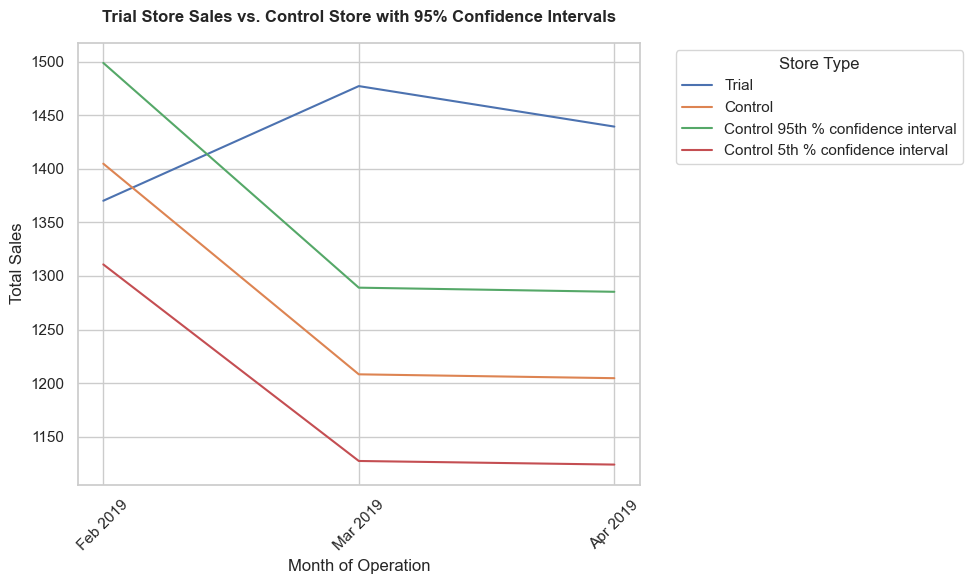

In [601]:
# Set the figure size for better readability
plt.figure(figsize=(10,6))

# Create a line plot for total sales over time, colored by store type
sns.lineplot(data=trial_assessment, x='TransactionMonth', y='total_sales', hue='Store_type')

# Add a title to the plot
plt.title('Trial Store Sales vs. Control Store with 95% Confidence Intervals')

# Label the x-axis
plt.xlabel('Month of Operation')

# Label the y-axis
plt.ylabel('Total Sales')

# Add a legend to indicate store types (Trial, Control, and Confidence Intervals)
plt.legend(title='Store Type')

# Move the legend outside the plot for better visibility
plt.legend(title='Store Type', bbox_to_anchor=(1.05, 1), loc='upper left')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout to prevent overlapping labels
plt.tight_layout()

# Display the plot
plt.show()


The results show that the trial in store 88 is significantly different to its
control store in the trial period as the trial store performance lies outside the
5% to 95% confidence interval of the control store in two of the three trial
months.

## Assessing Customer Trends with Confidence Intervals  

To evaluate whether the trial store experienced a significant change in customer count during the trial period, we will follow the same approach as total sales.  

1. **Scale Pre-Trial Control Store Customers**  
   - Adjust the number of customers in the control store to match the trial store before the trial period.  
   
2. **Calculate  Differences**  
   - Compute the difference between the trial store and scaled control store customers.  

3. **Determine Confidence Intervals**  
   - Compute the standard deviation of percentage differences in customer counts during the pre-trial period.  
   - Define the 95th and 5th percentile confidence intervals (mean ± 2 * standard deviation).  

4. **Visualize the Results**  
   - Plot the trial store's customer count alongside the control store and its confidence intervals.  
   - If the trial store's customer count falls outside the confidence intervals, it suggests a significant change during the trial period.  

This approach allows us to visually assess whether the trial store had a notable increase or decrease in customers.

In [602]:
scaling_factor_cust = (
    preTrialMeasures[preTrialMeasures['STORE_NBR'] == 88]['ncustomers'].sum() /
    preTrialMeasures[preTrialMeasures['STORE_NBR'] == 237]['ncustomers'].sum()
)

# Extract customer data for the trial store (Store 77), keeping only relevant columns
pre_trial_store_cust = pre_trial_comparison[pre_trial_comparison['STORE_NBR'] == 88][['STORE_NBR', 'YEARMONTH', 'ncustomers']]

# Extract customer data for the control store (Store 233), keeping only relevant columns
pre_control_store_cust = pre_trial_comparison[pre_trial_comparison['STORE_NBR'] == 237][['STORE_NBR', 'YEARMONTH', 'ncustomers']]

# Scale the control store's total sales using the previously computed scaling factor
# This aligns the control store's performance with the trial store's pre-trial sales
pre_control_store_cust['scaled_cust'] = pre_control_store_cust['ncustomers'] * scaling_factor_cust

# Merge the trial store and control store sales data on YEARMONTH
# This allows us to directly compare their monthly sales performance
pre_trial_diff_cust = pd.merge(pre_trial_store_cust,pre_control_store_cust,on='YEARMONTH')

# Calculate the percentage difference in sales between the trial store and the scaled control store
# Formula: |(Total Sales of Trial Store - Scaled Sales of Control Store)| / Scaled Sales of Control Store
pre_trial_diff_cust['cust_diff'] = (
    abs(pre_trial_diff_cust['ncustomers_x'] - pre_trial_diff_cust['scaled_cust']) /
    pre_trial_diff_cust['scaled_cust']
) 

# Display the percentage difference results
pre_trial_diff_cust

,STORE_NBR_x,YEARMONTH,ncustomers_x,STORE_NBR_y,ncustomers_y,scaled_cust,cust_diff
0,88,201807,129,237,128,127.276836,0.013539
1,88,201808,131,237,135,134.237288,0.024116
2,88,201809,124,237,126,125.288136,0.010281
3,88,201810,123,237,123,122.305085,0.005682
4,88,201811,130,237,132,131.254237,0.009556
5,88,201812,126,237,124,123.299435,0.021902
6,88,201901,117,237,117,116.338983,0.005682


In [603]:
# Calculate the standard deviation of the percentage difference in customer count before the trial
std_dev_cust = np.std(pre_trial_diff_cust['cust_diff'], ddof=1) 

# Create a copy of the relevant columns from during_trial_measures for customer analysis
during_trial_cust_cf = during_trial_measures[['STORE_NBR', 'YEARMONTH', 'ncustomers']].copy()

# Assign store type: Label 'Trial' for Store 77, otherwise 'Control'
during_trial_cust_cf['Store_type'] = during_trial_cust_cf['STORE_NBR'].apply(
    lambda x: 'Trial' if x == 88 else 'Control'
)

# Calculate the confidence interval multiplier (95% CI is typically mean ± 2 * std dev)
multiplier = 2 * std_dev_cust

# Create a DataFrame for the 95th percentile confidence interval of control store customers
controlcust_95 = during_trial_cust_cf[during_trial_cust_cf['Store_type'] == 'Control'].copy()
# Increase customer count by the confidence interval multiplier (mean + 2 * std dev)
controlcust_95['ncustomers'] = controlcust_95['ncustomers'] * (1 + multiplier)
# Label it as the 95th percentile confidence interval
controlcust_95['Store_type'] = 'Control 95th % confidence interval'

# Create a DataFrame for the 5th percentile confidence interval of control store customers
controlcust_5 = during_trial_cust_cf[during_trial_cust_cf['Store_type'] == 'Control'].copy()
# Decrease customer count by the confidence interval multiplier (mean - 2 * std dev)
controlcust_5['ncustomers'] = controlcust_5['ncustomers'] * (1 - multiplier)
# Label it as the 5th percentile confidence interval
controlcust_5['Store_type'] = 'Control 5th % confidence interval'

# Combine all datasets into a single DataFrame for visualization
trial_cust_assessment = pd.concat([during_trial_cust_cf, controlcust_95, controlcust_5])

# Convert YEARMONTH column to datetime format for accurate plotting
trial_cust_assessment['YEARMONTH'] = pd.to_datetime(trial_cust_assessment['YEARMONTH'], format='%Y%m')

# Create a new column to display the date in "Month Year" format (e.g., "Feb 2019")
trial_cust_assessment['TransactionMonth'] = trial_cust_assessment['YEARMONTH'].dt.strftime('%b %Y')


**Visualizing the Data** 

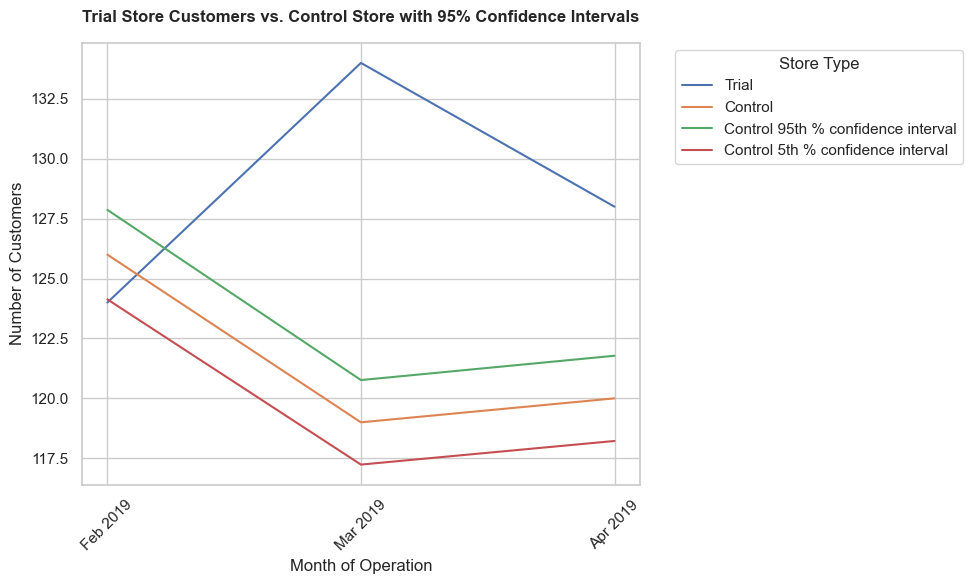

In [604]:
# Set the figure size for better readability
plt.figure(figsize=(10,6))

# Create a line plot for number of customers over time, colored by store type
sns.lineplot(data=trial_cust_assessment, x='TransactionMonth', y='ncustomers', hue='Store_type')

# Add a title to the plot
plt.title('Trial Store Customers vs. Control Store with 95% Confidence Intervals')

# Label the x-axis
plt.xlabel('Month of Operation')

# Label the y-axis
plt.ylabel('Number of Customers')

# Add a legend to indicate store types (Trial, Control, and Confidence Intervals)
plt.legend(title='Store Type')

# Move the legend outside the plot for better visibility
plt.legend(title='Store Type', bbox_to_anchor=(1.05, 1), loc='upper left')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout to prevent overlapping labels
plt.tight_layout()

# Display the plot
plt.show()


The results show that the trial in store 88 is significantly different to its
control store in the trial period as the trial store performance lies outside the
5% to 95% confidence interval of the control store in two of the three trial
months. 

### **Findings**  

The results indicate that the trial in **Store 88** had a significant impact on both **sales and customer count** compared to its control store during the trial period.  

- In **two out of the three trial months (March and April)**, the trial store's performance fell **outside the 5% to 95% confidence interval** of the control store for both **total sales and number of customers**, indicating a **statistically significant difference**.  
- However, in **February**, the difference in both **sales and customer count** was **not statistically significant**, suggesting that any observed variation in that month could be due to normal fluctuations rather than the trial intervention.  

Overall, these findings provide strong evidence that the trial intervention **influenced customer behavior and increased sales**, particularly in **March and April**, demonstrating its effectiveness.  


## Conclusion  

We have identified control stores **233, 155, and 237** for trial stores **77, 86, and 88**, respectively.  

The results indicate that trial stores **77 and 88** showed a **significant difference** in at least two of the three trial months for both **total sales and customer count**. However, this was **not the case for trial store 86**. Further investigation may be needed to determine whether the trial implementation differed for this store.  

Overall, the trial demonstrates a **notable increase in both sales and customer count**, suggesting that the intervention had a measurable impact on customer behavior. These insights provide strong evidence of the trial's effectiveness and can help inform future strategies for similar initiatives.  


In [605]:
measureOverTime.head()

,STORE_NBR,YEARMONTH,total_sales,ncustomers,nproducts,monthly_transaction,nChipsPerTxn,nTxnPerCust,avgPricePerUnit
0,1,201807,206.9,49,62,52,1.192308,1.061224,3.337097
1,1,201808,176.1,42,54,43,1.255814,1.023810,3.261111
2,1,201809,278.8,59,75,62,1.209677,1.050847,3.717333
3,1,201810,188.1,44,58,45,1.288889,1.022727,3.243103
4,1,201811,192.6,46,57,47,1.212766,1.021739,3.378947


In [606]:
sales_presentation = measureOverTime.groupby(by='YEARMONTH')['total_sales'].sum().reset_index()

In [607]:
sales_presentation

,YEARMONTH,total_sales
0,201807,165275.30
1,201808,158081.05
2,201809,160522.00
3,201810,164415.70
4,201811,160233.70
...,...,...
7,201902,150665.00
8,201903,166265.20
9,201904,159845.10
10,201905,156717.65


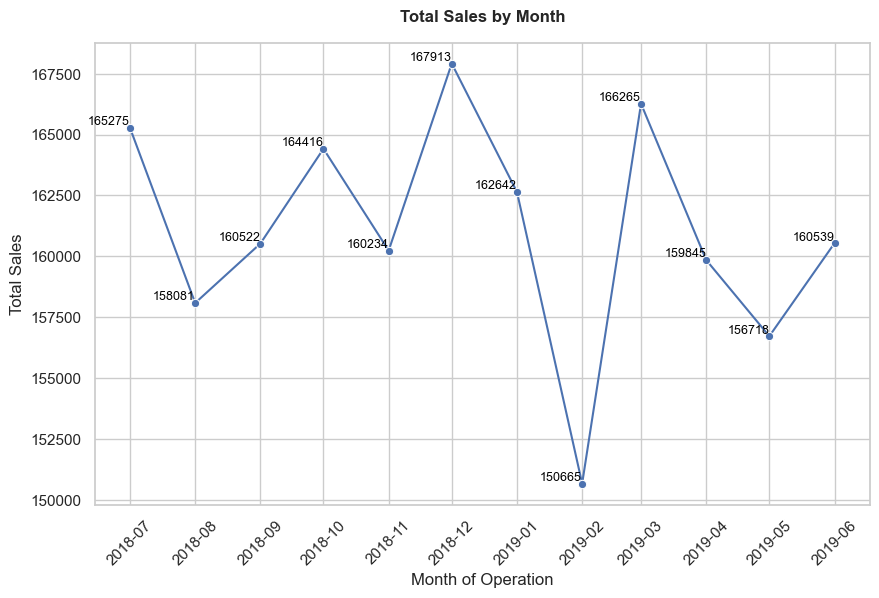

In [608]:
# Convert YEARMONTH to datetime format for plotting
sales_presentation['TransactionMonth'] = pd.to_datetime(sales_presentation['YEARMONTH'].astype(str) + '01', format='%Y%m%d')


import matplotlib.dates as mdates

# Plot total sales trends
plt.figure(figsize=(10,6))
sns.lineplot(data=sales_presentation, x='TransactionMonth', y='total_sales', marker='o')  # Add markers to highlight data points

# Add data labels
for x, y in zip(sales_presentation['TransactionMonth'], sales_presentation['total_sales']):
    plt.text(x, y, f'{y:.0f}', ha='right', va='bottom', fontsize=9, color='black')

# Formatting
plt.title('Total Sales by Month')
plt.xlabel('Month of Operation')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)

# Ensure all months are displayed
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))  
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  

plt.show()


In [609]:
sales_presentation

,YEARMONTH,total_sales,TransactionMonth
0,201807,165275.30,2018-07-01
1,201808,158081.05,2018-08-01
2,201809,160522.00,2018-09-01
3,201810,164415.70,2018-10-01
4,201811,160233.70,2018-11-01
...,...,...,...
7,201902,150665.00,2019-02-01
8,201903,166265.20,2019-03-01
9,201904,159845.10,2019-04-01
10,201905,156717.65,2019-05-01


In [610]:
customer_seg_sales_presentation = df.groupby(by='PREMIUM_CUSTOMER')['TOT_SALES'].sum().reset_index()
customer_seg_sales_presentation

,PREMIUM_CUSTOMER,TOT_SALES
0,Budget,676211.55
1,Mainstream,750744.50
2,Premium,506158.95


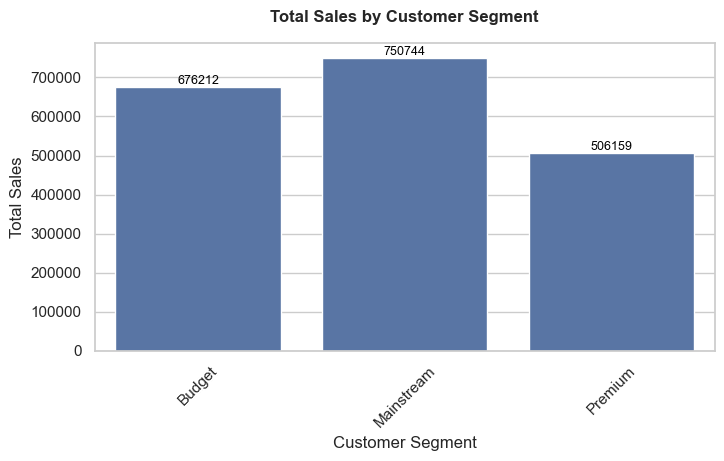

In [611]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot total sales as a bar chart
plt.figure(figsize=(8,4))
sns.barplot(data=customer_seg_sales_presentation, x='PREMIUM_CUSTOMER', y='TOT_SALES')

# Add data labels
for index, row in customer_seg_sales_presentation.iterrows():
    plt.text(index, row['TOT_SALES'], f'{row["TOT_SALES"]:.0f}', ha='center', va='bottom', fontsize=9, color='black')

# Formatting
plt.title('Total Sales by Customer Segment')
plt.xlabel('Customer Segment')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)

plt.show()

In [612]:
df.head()

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER,YEARMONTH
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium,201810
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream,201809
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget,201903
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget,201903
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream,201811


In [613]:
customer_seg_count_sales_presentation = df.groupby(by=['LIFESTAGE','PREMIUM_CUSTOMER'])['LYLTY_CARD_NBR'].count().reset_index()
customer_seg_count_sales_presentation

,LIFESTAGE,PREMIUM_CUSTOMER,LYLTY_CARD_NBR
0,MIDAGE SINGLES/COUPLES,Budget,5020
1,MIDAGE SINGLES/COUPLES,Mainstream,11874
2,MIDAGE SINGLES/COUPLES,Premium,8216
3,NEW FAMILIES,Budget,3005
4,NEW FAMILIES,Mainstream,2325
...,...,...,...
16,YOUNG FAMILIES,Mainstream,12907
17,YOUNG FAMILIES,Premium,11563
18,YOUNG SINGLES/COUPLES,Budget,9242
19,YOUNG SINGLES/COUPLES,Mainstream,20854


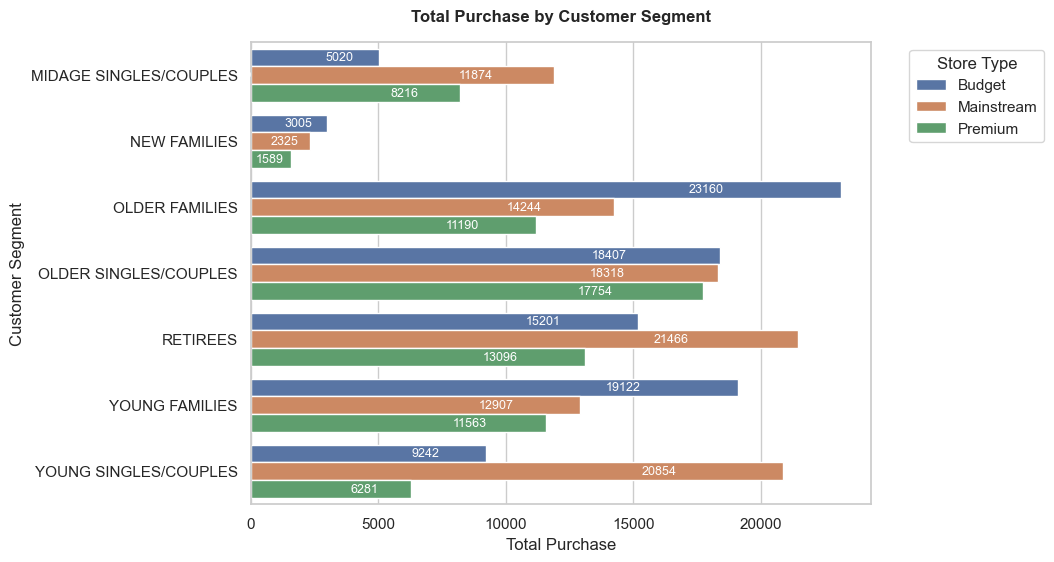

In [614]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set figure size
plt.figure(figsize=(8, 6))

# Create a horizontal bar chart
ax = sns.barplot(data=customer_seg_count_sales_presentation, 
                 y='LIFESTAGE', 
                 x='LYLTY_CARD_NBR', 
                 hue='PREMIUM_CUSTOMER', 
                 orient='h')  # Horizontal bars

# Add data labels inside the bars
for bars in ax.patches:
    ax.text(bars.get_width() - (bars.get_width() * 0.2),  # Adjust horizontal position
            bars.get_y() + bars.get_height() / 2,  # Align to center of the bar
            f'{bars.get_width():.0f}',  # Format as integer
            ha='right',  # Align text to the right
            va='center',  # Align text vertically centered
            color='white',  # Make it visible inside the bar
            fontsize=9)

# Formatting
plt.title('Total Purchase by Customer Segment')
plt.xlabel('Total Purchase')
plt.ylabel('Customer Segment')

# Move the legend outside the plot for better visibility
plt.legend(title='Store Type', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()


In [615]:
presentation_trial_full = df.copy()
presentation_trial_full.head()

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER,YEARMONTH
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium,201810
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream,201809
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget,201903
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget,201903
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream,201811


In [616]:
presentation_trial_full = presentation_trial_full[(presentation_trial_full['YEARMONTH']>= 201902) & (presentation_trial_full['YEARMONTH']<= 201904) & presentation_trial_full['STORE_NBR'].isin([77,86,88,233,237,155])]

In [617]:
presentation_trial_full['Store_type'] = presentation_trial_full['STORE_NBR'].apply(
    lambda x: 'Trial Store' if x in [77, 86, 88] else 'Control Store'
)

In [618]:
presentation_trial_full

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER,YEARMONTH,Store_type
73365,77000,2019-03-28,77,74911,18,Cheetos Chs & Bacon Balls 190g,1,3.3,190,CHEETOS,MIDAGE SINGLES/COUPLES,Budget,201903,Trial Store
73366,77000,2019-04-13,77,74912,69,Smiths Chip Thinly S/Cream&Onion 175g,1,3.0,175,SMITHS,MIDAGE SINGLES/COUPLES,Budget,201904,Trial Store
73368,77001,2019-02-27,77,74913,7,Smiths Crinkle Original 330g,2,11.4,330,SMITHS,YOUNG FAMILIES,Mainstream,201902,Trial Store
73372,77003,2019-03-18,77,74917,80,Natural ChipCo Sea Salt & Vinegr 175g,1,3.0,175,NATURAL,OLDER FAMILIES,Mainstream,201903,Trial Store
73377,77007,2019-03-20,77,74923,3,Kettle Sensations Camembert & Fig 150g,2,9.2,150,KETTLE,OLDER SINGLES/COUPLES,Premium,201903,Trial Store
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236963,237379,2019-02-12,237,241850,71,Twisties Cheese Burger 250g,2,8.6,250,TWISTIES,NEW FAMILIES,Budget,201902,Control Store
236970,237380,2019-03-24,237,241857,60,Kettle Tortilla ChpsFeta&Garlic 150g,2,9.2,150,KETTLE,RETIREES,Budget,201903,Control Store
236981,237382,2019-02-01,237,241868,20,Doritos Cheese Supreme 330g,2,11.4,330,DORITOS,OLDER SINGLES/COUPLES,Mainstream,201902,Control Store
236984,237383,2019-03-21,237,241871,99,Pringles Sthrn FriedChicken 134g,2,7.4,134,PRINGLES,RETIREES,Premium,201903,Control Store


In [619]:

presentation_trial_full = presentation_trial_full.groupby(by=['YEARMONTH','Store_type'])['TOT_SALES'].count().reset_index()

In [620]:
presentation_trial_full

,YEARMONTH,Store_type,TOT_SALES
0,201902,Control Store,331
1,201902,Trial Store,338
2,201903,Control Store,298
3,201903,Trial Store,367
4,201904,Control Store,290
5,201904,Trial Store,337


In [621]:
# Convert YEARMONTH to datetime format for plotting
presentation_trial_full['TransactionMonth'] = pd.to_datetime(presentation_trial_full['YEARMONTH'].astype(str) + '01', format='%Y%m%d')


import matplotlib.dates as mdates

# Plot total sales trends
plt.figure(figsize=(10,6))
sns.lineplot(data=presentation_trial_full, x='TransactionMonth', y='TXN_ID',hue='Store_type', marker='o')  # Add markers to highlight data points

# Add data labels
for x, y in zip(presentation_trial_full['TransactionMonth'], presentation_trial_full['TXN_ID']):
    plt.text(x, y, f'{y:.0f}', ha='right', va='bottom', fontsize=9, color='black')

# Formatting
plt.title('Number of Transactions')
plt.xlabel('Month of Operation')
plt.ylabel('Transactions')
plt.xticks(rotation=45)

# Ensure all months are displayed
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))  
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  

plt.show()


ValueError: Could not interpret value `TXN_ID` for `y`. An entry with this name does not appear in `data`.

<Figure size 1000x600 with 0 Axes>